In [1]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

import json

/Users/1233day/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
train = pd.read_csv('../train.csv').drop(columns=['ID'])
test = pd.read_csv('../test.csv').drop(columns=['ID'])
train.shape, test.shape

((256351, 68), (90067, 67))

In [5]:
train.head()

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
1,TRYBLT,만45-50세,NaN,IVF,ICSI,0,알 수 없음,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
2,TRVNRY,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,2.0,NaN,0
3,TRJXFG,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
4,TRVNRY,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0


In [6]:
train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [7]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()

시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

In [8]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [9]:
nan_col_list = ['착상 전 유전 검사 사용 여부','PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [10]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [11]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 64), (90067, 63))

In [12]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [13]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [14]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [15]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '특정 시술 유형',
       '배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부',
       '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애',
       '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', '배아 생성 주요 이유', '총 시술 횟수',
       '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수',
       'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '총 생성 배아 수',
       '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처',
       '난자 기증자 나이', '정자 기증자 나이', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부',
       '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일',
       '배아 해동 경과일', '임신 성공 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인', '남성 불임 원인',
       '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [16]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', 'PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인'] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = [ '임신 시도 또는 마지막 임신 경과 연수',"총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '총 생성 배아 수','미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [17]:
len(categorical_columns) + len(numeric_columns)

58

In [18]:
def make_feature(df):
  #df['연령 가중치'] = df['시술 당시 나이'].map(age_weight_dict)

  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  # df['저장 배아 비율2'] = (df['저장된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['해동 배아 생존율2'] = (df['해동된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)
  #df['나이보정 배아 이식 수'] = df['이식된 배아 수']*df['연령 가중치']

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  #df['IVF 시술 성공률'] = (df['IVF 임신 횟수'])/ (df['IVF 시술 횟수'] + 1)
  #df['DI 시술 성공률'] = (df['DI 임신 횟수']) / (df['DI 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  #df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  #df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  #df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  #df = df.drop(columns = ['연령 가중치'])

  return df

In [19]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 66), (90067, 66))

In [20]:
y.value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [21]:
if not os.path.exists('./weight'):
    os.makedirs('./weight')

In [22]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1000, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True)
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "./weight/cat_fold_cpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
         "random_state":  trial.suggest_int('random_state', 42, 42),
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5, log=False),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1, log=False),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1, log=False),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [23]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 42

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    best_val_auc = 0

    # ---------------- CatBoost Optuna 튜닝 ----------------
    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 20)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    cat_model_path = f"./weight/cat_fold_cpu{idx}.cbm"
    model_cat = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=42, task_type="CPU")
    model_cat.load_model(cat_model_path)

    # ---------------- LightGBM Optuna 튜닝 ----------------
    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 20)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    # lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred_cat = model_cat.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred_cat)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_cat+val_pred_lgbm)/2)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred_cat = model_cat.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_cat+test_pred_lgbm)/2)

[I 2025-02-21 03:57:35,096] A new study created in memory with name: no-name-e26f4f8f-9aad-49ea-8ad8-2eeb5a2441db


Seed 42 Start!
0:	test: 0.7260206	best: 0.7260206 (0)	total: 194ms	remaining: 5m 38s
300:	test: 0.7401021	best: 0.7427849 (122)	total: 39.9s	remaining: 3m 11s


[I 2025-02-21 03:58:32,170] Trial 0 finished with value: 0.7427848881006336 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7427848881006336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427848881
bestIteration = 122

Shrink model to first 123 iterations.
저장 완료
0:	test: 0.7029065	best: 0.7029065 (0)	total: 77.3ms	remaining: 1m 41s
300:	test: 0.7385324	best: 0.7385324 (300)	total: 15.8s	remaining: 53.1s
600:	test: 0.7414356	best: 0.7414356 (600)	total: 31.9s	remaining: 37.8s
900:	test: 0.7423499	best: 0.7423499 (900)	total: 48.8s	remaining: 22.2s
1200:	test: 0.7428009	best: 0.7428009 (1200)	total: 1m 6s	remaining: 6.11s


[I 2025-02-21 03:59:44,773] Trial 1 finished with value: 0.743019372482248 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.743019372482248.


1311:	test: 0.7430194	best: 0.7430194 (1311)	total: 1m 12s	remaining: 0us

bestTest = 0.7430193725
bestIteration = 1311

저장 완료
0:	test: 0.7213054	best: 0.7213054 (0)	total: 105ms	remaining: 3m 51s
300:	test: 0.7395788	best: 0.7395788 (300)	total: 23.9s	remaining: 2m 30s
600:	test: 0.7420182	best: 0.7420182 (600)	total: 47.6s	remaining: 2m 6s
900:	test: 0.7428479	best: 0.7428479 (900)	total: 1m 11s	remaining: 1m 42s
1200:	test: 0.7432594	best: 0.7432594 (1199)	total: 1m 34s	remaining: 1m 19s
1500:	test: 0.7435515	best: 0.7435569 (1491)	total: 1m 58s	remaining: 55.2s
1800:	test: 0.7437613	best: 0.7437613 (1800)	total: 2m 20s	remaining: 31.3s
2100:	test: 0.7438928	best: 0.7438942 (2085)	total: 2m 45s	remaining: 7.96s


[I 2025-02-21 04:02:39,909] Trial 2 finished with value: 0.743920450210648 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.743920450210648.


2201:	test: 0.7439203	best: 0.7439205 (2200)	total: 2m 54s	remaining: 0us

bestTest = 0.7439204502
bestIteration = 2200

Shrink model to first 2201 iterations.
저장 완료
0:	test: 0.7029065	best: 0.7029065 (0)	total: 67.9ms	remaining: 3m
300:	test: 0.7415936	best: 0.7415936 (300)	total: 16s	remaining: 2m 5s
600:	test: 0.7428906	best: 0.7428906 (600)	total: 32.2s	remaining: 1m 50s
900:	test: 0.7433228	best: 0.7433661 (816)	total: 49.1s	remaining: 1m 36s


[I 2025-02-21 04:03:41,661] Trial 3 finished with value: 0.743366103942534 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.743920450210648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433661039
bestIteration = 816

Shrink model to first 817 iterations.
0:	test: 0.7077049	best: 0.7077049 (0)	total: 82.5ms	remaining: 2m 12s
300:	test: 0.7428068	best: 0.7429811 (293)	total: 21.8s	remaining: 1m 34s


[I 2025-02-21 04:04:26,629] Trial 4 finished with value: 0.742981111035077 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.743920450210648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742981111
bestIteration = 293

Shrink model to first 294 iterations.
0:	test: 0.7007101	best: 0.7007101 (0)	total: 51.4ms	remaining: 1m 54s
300:	test: 0.7419336	best: 0.7419336 (300)	total: 12.9s	remaining: 1m 22s
600:	test: 0.7430233	best: 0.7431298 (579)	total: 27.1s	remaining: 1m 13s
900:	test: 0.7429784	best: 0.7431352 (808)	total: 41.9s	remaining: 1m 1s


[I 2025-02-21 04:05:18,684] Trial 5 finished with value: 0.7431352408186841 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.743920450210648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431352408
bestIteration = 808

Shrink model to first 809 iterations.
0:	test: 0.7235987	best: 0.7235987 (0)	total: 101ms	remaining: 3m 13s
300:	test: 0.7431181	best: 0.7431543 (293)	total: 28.6s	remaining: 2m 33s
600:	test: 0.7433270	best: 0.7433270 (600)	total: 59.9s	remaining: 2m 10s
900:	test: 0.7429051	best: 0.7433515 (602)	total: 1m 32s	remaining: 1m 44s


[I 2025-02-21 04:06:52,032] Trial 6 finished with value: 0.7433514839084447 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.743920450210648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433514839
bestIteration = 602

Shrink model to first 603 iterations.
0:	test: 0.7007101	best: 0.7007101 (0)	total: 51.7ms	remaining: 1m 52s
300:	test: 0.7432101	best: 0.7432184 (299)	total: 13.6s	remaining: 1m 24s
600:	test: 0.7436421	best: 0.7436960 (559)	total: 29.6s	remaining: 1m 18s


[I 2025-02-21 04:07:34,996] Trial 7 finished with value: 0.7436960314961754 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.743920450210648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7436960315
bestIteration = 559

Shrink model to first 560 iterations.
0:	test: 0.7254150	best: 0.7254150 (0)	total: 120ms	remaining: 2m 15s
300:	test: 0.7408965	best: 0.7428681 (71)	total: 44.6s	remaining: 2m 2s


[I 2025-02-21 04:08:30,659] Trial 8 finished with value: 0.7428681134983821 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.743920450210648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428681135
bestIteration = 71

Shrink model to first 72 iterations.
0:	test: 0.7007101	best: 0.7007101 (0)	total: 53.7ms	remaining: 1m 26s
300:	test: 0.7434893	best: 0.7434954 (298)	total: 13.7s	remaining: 59.5s
600:	test: 0.7434263	best: 0.7435985 (342)	total: 28.1s	remaining: 47.1s


[I 2025-02-21 04:09:01,167] Trial 9 finished with value: 0.7435984759237858 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 2 with value: 0.743920450210648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7435984759
bestIteration = 342

Shrink model to first 343 iterations.
0:	test: 0.7213478	best: 0.7213478 (0)	total: 94.5ms	remaining: 4m 34s
300:	test: 0.7388227	best: 0.7388227 (300)	total: 24.1s	remaining: 3m 28s
600:	test: 0.7415140	best: 0.7415140 (600)	total: 48.1s	remaining: 3m 4s
900:	test: 0.7425758	best: 0.7425771 (899)	total: 1m 11s	remaining: 2m 39s
1200:	test: 0.7430765	best: 0.7430765 (1200)	total: 1m 35s	remaining: 2m 16s
1500:	test: 0.7434111	best: 0.7434112 (1499)	total: 1m 59s	remaining: 1m 52s
1800:	test: 0.7436267	best: 0.7436272 (1797)	total: 2m 22s	remaining: 1m 27s
2100:	test: 0.7437909	best: 0.7437918 (2099)	total: 2m 47s	remaining: 1m 4s
2400:	test: 0.7438821	best: 0.7438834 (2394)	total: 3m 11s	remaining: 40.4s
2700:	test: 0.7439983	best: 0.7439983 (2700)	total: 3m 37s	remaining: 16.7s


[I 2025-02-21 04:12:57,857] Trial 10 finished with value: 0.7440425326571736 and parameters: {'iterations': 2908, 'depth': 8, 'learning_rate': 0.005716995335047832, 'l2_leaf_reg': 53.77119408946009}. Best is trial 10 with value: 0.7440425326571736.


2907:	test: 0.7440397	best: 0.7440425 (2893)	total: 3m 56s	remaining: 0us

bestTest = 0.7440425327
bestIteration = 2893

Shrink model to first 2894 iterations.
저장 완료
0:	test: 0.7212877	best: 0.7212877 (0)	total: 91.4ms	remaining: 4m 27s
300:	test: 0.7390725	best: 0.7390725 (300)	total: 23s	remaining: 3m 20s
600:	test: 0.7417411	best: 0.7417412 (599)	total: 47.9s	remaining: 3m 5s
900:	test: 0.7426824	best: 0.7426824 (900)	total: 1m 12s	remaining: 2m 43s
1200:	test: 0.7431266	best: 0.7431274 (1198)	total: 1m 36s	remaining: 2m 18s
1500:	test: 0.7434055	best: 0.7434055 (1500)	total: 1m 59s	remaining: 1m 53s
1800:	test: 0.7436111	best: 0.7436111 (1798)	total: 2m 22s	remaining: 1m 29s
2100:	test: 0.7437734	best: 0.7437737 (2095)	total: 2m 46s	remaining: 1m 5s
2400:	test: 0.7438748	best: 0.7438755 (2375)	total: 3m 12s	remaining: 42.5s
2700:	test: 0.7439095	best: 0.7439095 (2700)	total: 3m 39s	remaining: 18.6s


[I 2025-02-21 04:16:58,300] Trial 11 finished with value: 0.743961804815493 and parameters: {'iterations': 2930, 'depth': 8, 'learning_rate': 0.006402408540446873, 'l2_leaf_reg': 83.11832707510945}. Best is trial 10 with value: 0.7440425326571736.


2929:	test: 0.7439612	best: 0.7439618 (2921)	total: 3m 59s	remaining: 0us

bestTest = 0.7439618048
bestIteration = 2921

Shrink model to first 2922 iterations.
0:	test: 0.7077047	best: 0.7077047 (0)	total: 80.8ms	remaining: 3m 57s
300:	test: 0.7431377	best: 0.7431377 (300)	total: 21.6s	remaining: 3m 9s
600:	test: 0.7437783	best: 0.7438105 (510)	total: 45.1s	remaining: 2m 55s


[I 2025-02-21 04:17:59,966] Trial 12 finished with value: 0.7438105498023043 and parameters: {'iterations': 2941, 'depth': 7, 'learning_rate': 0.04193178467290182, 'l2_leaf_reg': 1.5372567535251194}. Best is trial 10 with value: 0.7440425326571736.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7438105498
bestIteration = 510

Shrink model to first 511 iterations.
0:	test: 0.7213056	best: 0.7213056 (0)	total: 92.5ms	remaining: 4m 3s
300:	test: 0.7401021	best: 0.7401021 (300)	total: 23.3s	remaining: 3m
600:	test: 0.7423563	best: 0.7423563 (600)	total: 47.1s	remaining: 2m 39s
900:	test: 0.7430269	best: 0.7430269 (900)	total: 1m 11s	remaining: 2m 16s
1200:	test: 0.7434065	best: 0.7434065 (1200)	total: 1m 34s	remaining: 1m 53s
1500:	test: 0.7436386	best: 0.7436386 (1500)	total: 1m 57s	remaining: 1m 29s
1800:	test: 0.7438612	best: 0.7438612 (1797)	total: 2m 22s	remaining: 1m 6s
2100:	test: 0.7439732	best: 0.7439739 (2094)	total: 2m 50s	remaining: 43.7s
2400:	test: 0.7440470	best: 0.7440476 (2395)	total: 3m 19s	remaining: 19.7s


[I 2025-02-21 04:21:42,461] Trial 13 finished with value: 0.7440620326537548 and parameters: {'iterations': 2638, 'depth': 8, 'learning_rate': 0.007940569964231549, 'l2_leaf_reg': 65.5477287928456}. Best is trial 13 with value: 0.7440620326537548.


2637:	test: 0.7440563	best: 0.7440620 (2547)	total: 3m 42s	remaining: 0us

bestTest = 0.7440620327
bestIteration = 2547

Shrink model to first 2548 iterations.
저장 완료
0:	test: 0.7215048	best: 0.7215048 (0)	total: 95.2ms	remaining: 4m 6s
300:	test: 0.7430457	best: 0.7430457 (300)	total: 24.4s	remaining: 3m 5s
600:	test: 0.7437367	best: 0.7437388 (599)	total: 51.2s	remaining: 2m 49s
900:	test: 0.7439590	best: 0.7439728 (891)	total: 1m 19s	remaining: 2m 27s
1200:	test: 0.7438819	best: 0.7439898 (963)	total: 1m 47s	remaining: 2m 3s


[I 2025-02-21 04:23:35,833] Trial 14 finished with value: 0.7439897623548798 and parameters: {'iterations': 2584, 'depth': 8, 'learning_rate': 0.021820476043467027, 'l2_leaf_reg': 3.4437900071734124}. Best is trial 13 with value: 0.7440620326537548.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439897624
bestIteration = 963

Shrink model to first 964 iterations.
0:	test: 0.7029389	best: 0.7029389 (0)	total: 84.8ms	remaining: 3m 38s
300:	test: 0.7425499	best: 0.7425499 (300)	total: 20.7s	remaining: 2m 36s
600:	test: 0.7433687	best: 0.7433857 (590)	total: 41.4s	remaining: 2m 16s
900:	test: 0.7436268	best: 0.7436268 (900)	total: 1m 2s	remaining: 1m 55s
1200:	test: 0.7436623	best: 0.7436955 (1077)	total: 1m 22s	remaining: 1m 34s
1500:	test: 0.7437280	best: 0.7437341 (1493)	total: 1m 43s	remaining: 1m 14s
1800:	test: 0.7437075	best: 0.7437373 (1739)	total: 2m 3s	remaining: 53.6s
2100:	test: 0.7437351	best: 0.7437440 (2095)	total: 2m 24s	remaining: 33s
2400:	test: 0.7437611	best: 0.7437806 (2360)	total: 2m 45s	remaining: 12.3s


[I 2025-02-21 04:26:34,334] Trial 15 finished with value: 0.7437805672174571 and parameters: {'iterations': 2580, 'depth': 6, 'learning_rate': 0.02945133331652104, 'l2_leaf_reg': 23.599533103540818}. Best is trial 13 with value: 0.7440620326537548.


2579:	test: 0.7436857	best: 0.7437806 (2360)	total: 2m 57s	remaining: 0us

bestTest = 0.7437805672
bestIteration = 2360

Shrink model to first 2361 iterations.
0:	test: 0.7235986	best: 0.7235986 (0)	total: 102ms	remaining: 4m 38s
300:	test: 0.7424218	best: 0.7424218 (300)	total: 26.6s	remaining: 3m 34s
600:	test: 0.7431937	best: 0.7432150 (581)	total: 55.6s	remaining: 3m 16s
900:	test: 0.7433472	best: 0.7433544 (863)	total: 1m 25s	remaining: 2m 53s


[I 2025-02-21 04:28:28,039] Trial 16 finished with value: 0.743354430151056 and parameters: {'iterations': 2729, 'depth': 9, 'learning_rate': 0.015196777855232777, 'l2_leaf_reg': 0.8271390033231544}. Best is trial 13 with value: 0.7440620326537548.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433544302
bestIteration = 863

Shrink model to first 864 iterations.
0:	test: 0.7230093	best: 0.7230093 (0)	total: 104ms	remaining: 4m 14s
300:	test: 0.7435253	best: 0.7435258 (299)	total: 28.4s	remaining: 3m 24s
600:	test: 0.7436610	best: 0.7437058 (569)	total: 1m	remaining: 3m 6s
900:	test: 0.7436090	best: 0.7437783 (667)	total: 1m 34s	remaining: 2m 43s


[I 2025-02-21 04:30:10,360] Trial 17 finished with value: 0.7437783277554184 and parameters: {'iterations': 2462, 'depth': 9, 'learning_rate': 0.03567864846396537, 'l2_leaf_reg': 15.02746182464784}. Best is trial 13 with value: 0.7440620326537548.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437783278
bestIteration = 667

Shrink model to first 668 iterations.
0:	test: 0.7029006	best: 0.7029006 (0)	total: 70.2ms	remaining: 2m 44s
300:	test: 0.7432865	best: 0.7432910 (298)	total: 19.1s	remaining: 2m 9s
600:	test: 0.7436509	best: 0.7436651 (568)	total: 38.8s	remaining: 1m 53s
900:	test: 0.7438257	best: 0.7438337 (837)	total: 58.7s	remaining: 1m 34s
1200:	test: 0.7438851	best: 0.7438901 (990)	total: 1m 18s	remaining: 1m 15s
1500:	test: 0.7439259	best: 0.7439346 (1468)	total: 1m 39s	remaining: 56s
1800:	test: 0.7438749	best: 0.7439384 (1545)	total: 1m 59s	remaining: 36.4s


[I 2025-02-21 04:32:13,194] Trial 18 finished with value: 0.7439383659069572 and parameters: {'iterations': 2350, 'depth': 6, 'learning_rate': 0.05222311239303098, 'l2_leaf_reg': 98.43219242781147}. Best is trial 13 with value: 0.7440620326537548.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439383659
bestIteration = 1545

Shrink model to first 1546 iterations.
0:	test: 0.7215062	best: 0.7215062 (0)	total: 92.8ms	remaining: 4m 36s
300:	test: 0.7416545	best: 0.7429487 (188)	total: 25.8s	remaining: 3m 49s


[I 2025-02-21 04:32:56,074] Trial 19 finished with value: 0.7429486626595808 and parameters: {'iterations': 2983, 'depth': 8, 'learning_rate': 0.09179224566434406, 'l2_leaf_reg': 0.20751615353789304}. Best is trial 13 with value: 0.7440620326537548.
[I 2025-02-21 04:32:56,080] A new study created in memory with name: no-name-c8c1b3d0-9b9b-498e-bc2b-7122180025be


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429486627
bestIteration = 188

Shrink model to first 189 iterations.


[I 2025-02-21 04:33:15,977] Trial 0 finished with value: 0.7429013718920625 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7429013718920625.
[I 2025-02-21 04:33:18,081] Trial 1 finished with value: 0.7399748595767962 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7429013718920625.
[I 2025-02-21 04:33:36,881] Trial 2 finished with value: 0.7439483759846158 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7440620326537548
LGBM val score : 0.7439849578352579
Ensemble val score : 0.7442756312723847


[I 2025-02-21 04:36:37,286] A new study created in memory with name: no-name-6d2f0a7a-83ed-4007-83b3-5437dbc950ae


0:	test: 0.7124965	best: 0.7124965 (0)	total: 105ms	remaining: 3m 3s
300:	test: 0.7281013	best: 0.7306657 (146)	total: 40.3s	remaining: 3m 13s


[I 2025-02-21 04:37:38,857] Trial 0 finished with value: 0.7306657347085622 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7306657347085622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7306657347
bestIteration = 146

Shrink model to first 147 iterations.
저장 완료
0:	test: 0.6959434	best: 0.6959434 (0)	total: 53ms	remaining: 1m 9s
300:	test: 0.7270817	best: 0.7270817 (300)	total: 16s	remaining: 53.8s
600:	test: 0.7298739	best: 0.7298739 (600)	total: 32.3s	remaining: 38.2s
900:	test: 0.7309587	best: 0.7309587 (900)	total: 48.6s	remaining: 22.2s
1200:	test: 0.7316179	best: 0.7316179 (1200)	total: 1m 6s	remaining: 6.11s


[I 2025-02-21 04:38:51,503] Trial 1 finished with value: 0.7319087483785077 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7319087483785077.


1311:	test: 0.7319087	best: 0.7319087 (1311)	total: 1m 12s	remaining: 0us

bestTest = 0.7319087484
bestIteration = 1311

저장 완료
0:	test: 0.7122043	best: 0.7122043 (0)	total: 73.7ms	remaining: 2m 42s
300:	test: 0.7277428	best: 0.7277428 (300)	total: 23.3s	remaining: 2m 27s
600:	test: 0.7302203	best: 0.7302203 (600)	total: 46.7s	remaining: 2m 4s
900:	test: 0.7312620	best: 0.7312644 (899)	total: 1m 10s	remaining: 1m 41s
1200:	test: 0.7317642	best: 0.7317652 (1197)	total: 1m 33s	remaining: 1m 17s
1500:	test: 0.7320632	best: 0.7320658 (1495)	total: 1m 56s	remaining: 54.3s
1800:	test: 0.7322934	best: 0.7322937 (1799)	total: 2m 19s	remaining: 31s
2100:	test: 0.7324368	best: 0.7324371 (2097)	total: 2m 44s	remaining: 7.9s


[I 2025-02-21 04:41:45,491] Trial 2 finished with value: 0.7324655333266944 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7324655333266944.


2201:	test: 0.7324655	best: 0.7324655 (2201)	total: 2m 53s	remaining: 0us

bestTest = 0.7324655333
bestIteration = 2201

저장 완료
0:	test: 0.6959154	best: 0.6959154 (0)	total: 53.7ms	remaining: 2m 23s
300:	test: 0.7300602	best: 0.7300602 (300)	total: 15.1s	remaining: 1m 58s
600:	test: 0.7316990	best: 0.7316990 (600)	total: 31.3s	remaining: 1m 47s
900:	test: 0.7322716	best: 0.7323353 (833)	total: 48.2s	remaining: 1m 34s
1200:	test: 0.7323773	best: 0.7323957 (999)	total: 1m 5s	remaining: 1m 19s
1500:	test: 0.7323415	best: 0.7324351 (1334)	total: 1m 22s	remaining: 1m 4s
1800:	test: 0.7322809	best: 0.7324641 (1581)	total: 1m 40s	remaining: 48s


[I 2025-02-21 04:43:30,609] Trial 3 finished with value: 0.7324641076382541 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7324655333266944.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7324641076
bestIteration = 1581

Shrink model to first 1582 iterations.
0:	test: 0.7109428	best: 0.7109428 (0)	total: 64.7ms	remaining: 1m 43s
300:	test: 0.7315699	best: 0.7316028 (299)	total: 21.7s	remaining: 1m 34s
600:	test: 0.7313225	best: 0.7317406 (356)	total: 45.3s	remaining: 1m 15s


[I 2025-02-21 04:44:20,518] Trial 4 finished with value: 0.7317406124531971 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.7324655333266944.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7317406125
bestIteration = 356

Shrink model to first 357 iterations.
0:	test: 0.6901027	best: 0.6901027 (0)	total: 44.8ms	remaining: 1m 39s
300:	test: 0.7304645	best: 0.7304645 (300)	total: 12.8s	remaining: 1m 21s
600:	test: 0.7322525	best: 0.7322525 (600)	total: 27s	remaining: 1m 12s
900:	test: 0.7327171	best: 0.7327243 (878)	total: 40.9s	remaining: 1m
1200:	test: 0.7327210	best: 0.7328027 (1066)	total: 55.2s	remaining: 47s


[I 2025-02-21 04:45:23,649] Trial 5 finished with value: 0.7328026629731461 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 5 with value: 0.7328026629731461.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.732802663
bestIteration = 1066

Shrink model to first 1067 iterations.
저장 완료
0:	test: 0.7120312	best: 0.7120312 (0)	total: 84.2ms	remaining: 2m 40s
300:	test: 0.7312977	best: 0.7312992 (299)	total: 26.7s	remaining: 2m 22s
600:	test: 0.7318020	best: 0.7318289 (574)	total: 55s	remaining: 1m 59s


[I 2025-02-21 04:46:47,242] Trial 6 finished with value: 0.7318288701130795 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 5 with value: 0.7328026629731461.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7318288701
bestIteration = 574

Shrink model to first 575 iterations.
0:	test: 0.6901027	best: 0.6901027 (0)	total: 45.6ms	remaining: 1m 39s
300:	test: 0.7321192	best: 0.7321249 (299)	total: 13.1s	remaining: 1m 21s
600:	test: 0.7323570	best: 0.7324593 (482)	total: 26.9s	remaining: 1m 10s
900:	test: 0.7324796	best: 0.7326498 (781)	total: 40.9s	remaining: 58.2s


[I 2025-02-21 04:47:36,841] Trial 7 finished with value: 0.732649752923825 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 5 with value: 0.7328026629731461.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7326497529
bestIteration = 781

Shrink model to first 782 iterations.
0:	test: 0.7125439	best: 0.7125439 (0)	total: 97.3ms	remaining: 1m 49s
300:	test: 0.7293349	best: 0.7311461 (102)	total: 41s	remaining: 1m 52s


[I 2025-02-21 04:48:33,263] Trial 8 finished with value: 0.7311460686033653 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 5 with value: 0.7328026629731461.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7311460686
bestIteration = 102

Shrink model to first 103 iterations.
0:	test: 0.6901171	best: 0.6901171 (0)	total: 43.1ms	remaining: 1m 9s
300:	test: 0.7322867	best: 0.7322975 (296)	total: 13.3s	remaining: 57.8s
600:	test: 0.7325797	best: 0.7327407 (484)	total: 27.2s	remaining: 45.7s


[I 2025-02-21 04:49:09,290] Trial 9 finished with value: 0.7327406753105694 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 5 with value: 0.7328026629731461.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7327406753
bestIteration = 484

Shrink model to first 485 iterations.
0:	test: 0.7109551	best: 0.7109551 (0)	total: 57.9ms	remaining: 2m 48s
300:	test: 0.7315626	best: 0.7315641 (297)	total: 18.3s	remaining: 2m 38s
600:	test: 0.7321578	best: 0.7323490 (437)	total: 38.3s	remaining: 2m 27s


[I 2025-02-21 04:49:56,945] Trial 10 finished with value: 0.732348976346963 and parameters: {'iterations': 2912, 'depth': 6, 'learning_rate': 0.04039108028802378, 'l2_leaf_reg': 0.00012816553469185968}. Best is trial 5 with value: 0.7328026629731461.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7323489763
bestIteration = 437

Shrink model to first 438 iterations.
0:	test: 0.6901171	best: 0.6901171 (0)	total: 43.7ms	remaining: 1m 46s
300:	test: 0.7322596	best: 0.7322634 (298)	total: 13.4s	remaining: 1m 35s
600:	test: 0.7323503	best: 0.7326404 (551)	total: 27.4s	remaining: 1m 23s


[I 2025-02-21 04:50:36,397] Trial 11 finished with value: 0.7326403886526764 and parameters: {'iterations': 2431, 'depth': 4, 'learning_rate': 0.07996027362065464, 'l2_leaf_reg': 0.01911547094560437}. Best is trial 5 with value: 0.7328026629731461.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7326403887
bestIteration = 551

Shrink model to first 552 iterations.
0:	test: 0.7109770	best: 0.7109770 (0)	total: 58.4ms	remaining: 1m 24s
300:	test: 0.7323393	best: 0.7323695 (299)	total: 18.8s	remaining: 1m 11s
600:	test: 0.7324456	best: 0.7324995 (435)	total: 38.8s	remaining: 54.9s


[I 2025-02-21 04:51:24,608] Trial 12 finished with value: 0.7324994520034878 and parameters: {'iterations': 1450, 'depth': 6, 'learning_rate': 0.055570753389735106, 'l2_leaf_reg': 0.5066719221096763}. Best is trial 5 with value: 0.7328026629731461.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.732499452
bestIteration = 435

Shrink model to first 436 iterations.
0:	test: 0.6901171	best: 0.6901171 (0)	total: 43.9ms	remaining: 1m 28s
300:	test: 0.7304333	best: 0.7304333 (300)	total: 12.6s	remaining: 1m 12s
600:	test: 0.7322987	best: 0.7323221 (596)	total: 26.2s	remaining: 1m 2s
900:	test: 0.7326554	best: 0.7326554 (900)	total: 40s	remaining: 50s
1200:	test: 0.7327838	best: 0.7328479 (1144)	total: 54.1s	remaining: 37.2s


[I 2025-02-21 04:52:30,385] Trial 13 finished with value: 0.7328478958180913 and parameters: {'iterations': 2027, 'depth': 4, 'learning_rate': 0.03169505566545232, 'l2_leaf_reg': 0.03698887108117822}. Best is trial 13 with value: 0.7328478958180913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7328478958
bestIteration = 1144

Shrink model to first 1145 iterations.
저장 완료
0:	test: 0.6959411	best: 0.6959411 (0)	total: 50.2ms	remaining: 1m 45s
300:	test: 0.7308468	best: 0.7308468 (300)	total: 15.5s	remaining: 1m 32s
600:	test: 0.7323855	best: 0.7323855 (600)	total: 32.2s	remaining: 1m 20s
900:	test: 0.7325871	best: 0.7326558 (836)	total: 49.2s	remaining: 1m 5s


[I 2025-02-21 04:53:33,335] Trial 14 finished with value: 0.7326557892648535 and parameters: {'iterations': 2102, 'depth': 5, 'learning_rate': 0.03219537126313048, 'l2_leaf_reg': 1.8009215363370865}. Best is trial 13 with value: 0.7328478958180913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7326557893
bestIteration = 836

Shrink model to first 837 iterations.
0:	test: 0.7109551	best: 0.7109551 (0)	total: 58.2ms	remaining: 2m 23s
300:	test: 0.7312345	best: 0.7312345 (300)	total: 18.4s	remaining: 2m 12s
600:	test: 0.7323431	best: 0.7323782 (508)	total: 38s	remaining: 1m 57s


[I 2025-02-21 04:54:25,550] Trial 15 finished with value: 0.7323781692041353 and parameters: {'iterations': 2467, 'depth': 6, 'learning_rate': 0.03697921388729446, 'l2_leaf_reg': 0.0044351655954852475}. Best is trial 13 with value: 0.7328478958180913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7323781692
bestIteration = 508

Shrink model to first 509 iterations.
0:	test: 0.7109459	best: 0.7109459 (0)	total: 66.3ms	remaining: 2m 8s
300:	test: 0.7308454	best: 0.7308539 (295)	total: 20.8s	remaining: 1m 53s
600:	test: 0.7319611	best: 0.7319784 (598)	total: 42.2s	remaining: 1m 34s
900:	test: 0.7325731	best: 0.7326231 (816)	total: 1m 5s	remaining: 1m 15s
1200:	test: 0.7321105	best: 0.7326253 (974)	total: 1m 28s	remaining: 55s


[I 2025-02-21 04:56:00,512] Trial 16 finished with value: 0.7326253454554287 and parameters: {'iterations': 1944, 'depth': 7, 'learning_rate': 0.02252924087608541, 'l2_leaf_reg': 0.01139713597201627}. Best is trial 13 with value: 0.7328478958180913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7326253455
bestIteration = 974

Shrink model to first 975 iterations.
0:	test: 0.6901273	best: 0.6901273 (0)	total: 45.4ms	remaining: 1m 47s
300:	test: 0.7316265	best: 0.7316265 (300)	total: 13.1s	remaining: 1m 30s
600:	test: 0.7325915	best: 0.7326142 (596)	total: 26.9s	remaining: 1m 19s
900:	test: 0.7326709	best: 0.7327357 (805)	total: 40.8s	remaining: 1m 6s


[I 2025-02-21 04:56:51,220] Trial 17 finished with value: 0.7327357032717747 and parameters: {'iterations': 2377, 'depth': 4, 'learning_rate': 0.050994057910544455, 'l2_leaf_reg': 0.10672984281821848}. Best is trial 13 with value: 0.7328478958180913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7327357033
bestIteration = 805

Shrink model to first 806 iterations.
0:	test: 0.6959154	best: 0.6959154 (0)	total: 47.4ms	remaining: 2m 4s
300:	test: 0.7306596	best: 0.7306618 (299)	total: 15.2s	remaining: 1m 57s
600:	test: 0.7322282	best: 0.7322448 (585)	total: 31.8s	remaining: 1m 47s
900:	test: 0.7325134	best: 0.7325160 (898)	total: 48.8s	remaining: 1m 33s
1200:	test: 0.7326194	best: 0.7327008 (1130)	total: 1m 6s	remaining: 1m 18s


[I 2025-02-21 04:58:10,718] Trial 18 finished with value: 0.7327007639767942 and parameters: {'iterations': 2630, 'depth': 5, 'learning_rate': 0.0300608998195083, 'l2_leaf_reg': 0.0002973385780079621}. Best is trial 13 with value: 0.7328478958180913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.732700764
bestIteration = 1130

Shrink model to first 1131 iterations.
0:	test: 0.7109353	best: 0.7109353 (0)	total: 63ms	remaining: 3m 3s
300:	test: 0.7304040	best: 0.7304040 (300)	total: 20.4s	remaining: 2m 57s
600:	test: 0.7316966	best: 0.7316966 (600)	total: 41.6s	remaining: 2m 40s
900:	test: 0.7322249	best: 0.7322266 (883)	total: 1m 4s	remaining: 2m 23s
1200:	test: 0.7321706	best: 0.7322698 (929)	total: 1m 27s	remaining: 2m 4s


[I 2025-02-21 04:59:40,653] Trial 19 finished with value: 0.7322697771699006 and parameters: {'iterations': 2918, 'depth': 7, 'learning_rate': 0.01738988667338674, 'l2_leaf_reg': 0.0016555673278698913}. Best is trial 13 with value: 0.7328478958180913.
[I 2025-02-21 04:59:40,656] A new study created in memory with name: no-name-31ab2fde-6ef6-4329-9178-69488742ec92


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7322697772
bestIteration = 929

Shrink model to first 930 iterations.


[I 2025-02-21 05:00:00,571] Trial 0 finished with value: 0.7324738769796557 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7324738769796557.
[I 2025-02-21 05:00:02,645] Trial 1 finished with value: 0.7275188670207257 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7324738769796557.
[I 2025-02-21 05:00:21,412] Trial 2 finished with value: 0.732356501916864 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial

Cat val score : 0.7328478958180913
LGBM val score : 0.7326602847504091
Ensemble val score : 0.7333542296633645


[I 2025-02-21 05:03:48,551] A new study created in memory with name: no-name-f8fe178b-ed36-482f-83a7-58c85cdb16df


0:	test: 0.7205392	best: 0.7205392 (0)	total: 99.3ms	remaining: 2m 53s
300:	test: 0.7375421	best: 0.7389777 (206)	total: 39.7s	remaining: 3m 10s


[I 2025-02-21 05:04:58,828] Trial 0 finished with value: 0.738977684965681 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.738977684965681.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738977685
bestIteration = 206

Shrink model to first 207 iterations.
저장 완료
0:	test: 0.7022268	best: 0.7022268 (0)	total: 51.3ms	remaining: 1m 7s
300:	test: 0.7321881	best: 0.7321881 (300)	total: 15.3s	remaining: 51.2s
600:	test: 0.7356347	best: 0.7356347 (600)	total: 31.2s	remaining: 36.9s
900:	test: 0.7369795	best: 0.7369795 (900)	total: 47s	remaining: 21.4s
1200:	test: 0.7377621	best: 0.7377621 (1200)	total: 1m 3s	remaining: 5.84s


[I 2025-02-21 05:06:08,415] Trial 1 finished with value: 0.7380295386124323 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.738977684965681.


1311:	test: 0.7380295	best: 0.7380295 (1311)	total: 1m 9s	remaining: 0us

bestTest = 0.7380295386
bestIteration = 1311

0:	test: 0.7184679	best: 0.7184679 (0)	total: 71.8ms	remaining: 2m 37s
300:	test: 0.7326310	best: 0.7326310 (300)	total: 23.2s	remaining: 2m 26s
600:	test: 0.7360377	best: 0.7360377 (600)	total: 46.7s	remaining: 2m 4s
900:	test: 0.7375594	best: 0.7375594 (900)	total: 1m 10s	remaining: 1m 41s
1200:	test: 0.7381712	best: 0.7381712 (1200)	total: 1m 34s	remaining: 1m 18s
1500:	test: 0.7385797	best: 0.7385797 (1500)	total: 1m 56s	remaining: 54.4s
1800:	test: 0.7388393	best: 0.7388393 (1800)	total: 2m 18s	remaining: 30.7s
2100:	test: 0.7390296	best: 0.7390324 (2077)	total: 2m 42s	remaining: 7.8s


[I 2025-02-21 05:09:00,102] Trial 2 finished with value: 0.739068817830106 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.739068817830106.


2201:	test: 0.7390672	best: 0.7390688 (2190)	total: 2m 51s	remaining: 0us

bestTest = 0.7390688178
bestIteration = 2190

Shrink model to first 2191 iterations.
저장 완료
0:	test: 0.7022274	best: 0.7022274 (0)	total: 51.6ms	remaining: 2m 17s
300:	test: 0.7357881	best: 0.7357881 (300)	total: 15.1s	remaining: 1m 58s
600:	test: 0.7378270	best: 0.7378270 (600)	total: 31.1s	remaining: 1m 46s
900:	test: 0.7385755	best: 0.7385999 (891)	total: 47.8s	remaining: 1m 33s
1200:	test: 0.7389663	best: 0.7389868 (1186)	total: 1m 4s	remaining: 1m 18s
1500:	test: 0.7390126	best: 0.7390444 (1434)	total: 1m 21s	remaining: 1m 3s
1800:	test: 0.7391518	best: 0.7391658 (1685)	total: 1m 38s	remaining: 47.4s


[I 2025-02-21 05:10:50,041] Trial 3 finished with value: 0.7391657765578792 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 3 with value: 0.7391657765578792.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391657766
bestIteration = 1685

Shrink model to first 1686 iterations.
저장 완료
0:	test: 0.7181967	best: 0.7181967 (0)	total: 62.5ms	remaining: 1m 40s
300:	test: 0.7384633	best: 0.7384700 (297)	total: 20.7s	remaining: 1m 29s
600:	test: 0.7386999	best: 0.7388268 (383)	total: 43.7s	remaining: 1m 13s
900:	test: 0.7384145	best: 0.7389288 (647)	total: 1m 7s	remaining: 52.6s


[I 2025-02-21 05:12:00,877] Trial 4 finished with value: 0.7389287508905787 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 3 with value: 0.7391657765578792.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389287509
bestIteration = 647

Shrink model to first 648 iterations.
0:	test: 0.6954896	best: 0.6954896 (0)	total: 44.7ms	remaining: 1m 39s
300:	test: 0.7361984	best: 0.7361984 (300)	total: 12.6s	remaining: 1m 20s
600:	test: 0.7382407	best: 0.7382407 (600)	total: 26s	remaining: 1m 10s
900:	test: 0.7387349	best: 0.7387517 (894)	total: 39.8s	remaining: 58.4s
1200:	test: 0.7389458	best: 0.7389504 (1199)	total: 53.8s	remaining: 45.8s
1500:	test: 0.7389476	best: 0.7389885 (1425)	total: 1m 7s	remaining: 32.7s


[I 2025-02-21 05:13:19,603] Trial 5 finished with value: 0.7389884828678237 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 3 with value: 0.7391657765578792.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389884829
bestIteration = 1425

Shrink model to first 1426 iterations.
0:	test: 0.7186091	best: 0.7186091 (0)	total: 81.7ms	remaining: 2m 36s
300:	test: 0.7381343	best: 0.7381373 (299)	total: 26.5s	remaining: 2m 21s
600:	test: 0.7391991	best: 0.7392549 (551)	total: 53.7s	remaining: 1m 57s
900:	test: 0.7392394	best: 0.7393838 (750)	total: 1m 24s	remaining: 1m 34s
1200:	test: 0.7392635	best: 0.7395341 (1038)	total: 1m 55s	remaining: 1m 8s


[I 2025-02-21 05:15:29,290] Trial 6 finished with value: 0.7395341482404312 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 6 with value: 0.7395341482404312.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7395341482
bestIteration = 1038

Shrink model to first 1039 iterations.
저장 완료
0:	test: 0.6954896	best: 0.6954896 (0)	total: 45.4ms	remaining: 1m 39s
300:	test: 0.7379912	best: 0.7379912 (300)	total: 13.2s	remaining: 1m 22s
600:	test: 0.7387081	best: 0.7387380 (595)	total: 27s	remaining: 1m 11s
900:	test: 0.7387865	best: 0.7388071 (827)	total: 41.1s	remaining: 58.5s
1200:	test: 0.7384714	best: 0.7388117 (909)	total: 55.1s	remaining: 45.1s


[I 2025-02-21 05:16:25,010] Trial 7 finished with value: 0.7388117173576083 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 6 with value: 0.7395341482404312.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388117174
bestIteration = 909

Shrink model to first 910 iterations.
0:	test: 0.7205513	best: 0.7205513 (0)	total: 97.9ms	remaining: 1m 50s
300:	test: 0.7375304	best: 0.7384510 (130)	total: 39.4s	remaining: 1m 48s


[I 2025-02-21 05:17:23,250] Trial 8 finished with value: 0.7384510420098678 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 6 with value: 0.7395341482404312.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738451042
bestIteration = 130

Shrink model to first 131 iterations.
0:	test: 0.6954896	best: 0.6954896 (0)	total: 43.3ms	remaining: 1m 9s
300:	test: 0.7384644	best: 0.7384718 (298)	total: 13.1s	remaining: 57s
600:	test: 0.7389154	best: 0.7389393 (594)	total: 27s	remaining: 45.3s
900:	test: 0.7390833	best: 0.7390833 (900)	total: 41.1s	remaining: 32.3s
1200:	test: 0.7388665	best: 0.7391056 (918)	total: 55.3s	remaining: 18.8s


[I 2025-02-21 05:18:19,563] Trial 9 finished with value: 0.739105607740165 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 6 with value: 0.7395341482404312.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391056077
bestIteration = 918

Shrink model to first 919 iterations.
0:	test: 0.7183270	best: 0.7183270 (0)	total: 73.1ms	remaining: 3m 31s
300:	test: 0.7390651	best: 0.7390940 (296)	total: 23.5s	remaining: 3m 22s
600:	test: 0.7392807	best: 0.7394068 (407)	total: 50s	remaining: 3m 10s
900:	test: 0.7391850	best: 0.7394295 (688)	total: 1m 16s	remaining: 2m 49s


[I 2025-02-21 05:19:44,581] Trial 10 finished with value: 0.7394295328906164 and parameters: {'iterations': 2891, 'depth': 8, 'learning_rate': 0.04002923340850424, 'l2_leaf_reg': 0.6899047876209637}. Best is trial 6 with value: 0.7395341482404312.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7394295329
bestIteration = 688

Shrink model to first 689 iterations.
0:	test: 0.7183270	best: 0.7183270 (0)	total: 73ms	remaining: 3m 29s
300:	test: 0.7385826	best: 0.7385842 (299)	total: 23.5s	remaining: 3m 20s
600:	test: 0.7391394	best: 0.7392235 (514)	total: 50.1s	remaining: 3m 9s


[I 2025-02-21 05:20:54,128] Trial 11 finished with value: 0.7392235387817359 and parameters: {'iterations': 2872, 'depth': 8, 'learning_rate': 0.04074542386789816, 'l2_leaf_reg': 0.5552661041119791}. Best is trial 6 with value: 0.7395341482404312.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392235388
bestIteration = 514

Shrink model to first 515 iterations.
0:	test: 0.7183270	best: 0.7183270 (0)	total: 73ms	remaining: 3m 7s
300:	test: 0.7381793	best: 0.7381793 (300)	total: 23.2s	remaining: 2m 55s
600:	test: 0.7393559	best: 0.7393939 (594)	total: 48.4s	remaining: 2m 38s
900:	test: 0.7393601	best: 0.7394988 (670)	total: 1m 15s	remaining: 2m 19s


[I 2025-02-21 05:22:15,765] Trial 12 finished with value: 0.7394987562198736 and parameters: {'iterations': 2568, 'depth': 8, 'learning_rate': 0.026439607654038348, 'l2_leaf_reg': 1.045790308564582}. Best is trial 6 with value: 0.7395341482404312.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7394987562
bestIteration = 670

Shrink model to first 671 iterations.
0:	test: 0.7186207	best: 0.7186207 (0)	total: 83.6ms	remaining: 3m 26s
300:	test: 0.7381510	best: 0.7381573 (295)	total: 26s	remaining: 3m 6s
600:	test: 0.7391562	best: 0.7391562 (600)	total: 53.6s	remaining: 2m 46s
900:	test: 0.7394280	best: 0.7394952 (890)	total: 1m 24s	remaining: 2m 26s
1200:	test: 0.7392956	best: 0.7395272 (997)	total: 1m 55s	remaining: 2m 1s


[I 2025-02-21 05:24:21,634] Trial 13 finished with value: 0.7395271508503704 and parameters: {'iterations': 2464, 'depth': 9, 'learning_rate': 0.023184328362643364, 'l2_leaf_reg': 3.371938605635963}. Best is trial 6 with value: 0.7395341482404312.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7395271509
bestIteration = 997

Shrink model to first 998 iterations.
0:	test: 0.7186253	best: 0.7186253 (0)	total: 86.7ms	remaining: 2m 41s
300:	test: 0.7373559	best: 0.7373559 (300)	total: 26.2s	remaining: 2m 16s
600:	test: 0.7387990	best: 0.7387990 (600)	total: 52.2s	remaining: 1m 49s
900:	test: 0.7394329	best: 0.7394329 (900)	total: 1m 21s	remaining: 1m 27s
1200:	test: 0.7396916	best: 0.7396951 (1199)	total: 1m 52s	remaining: 1m 2s
1500:	test: 0.7396877	best: 0.7397650 (1274)	total: 2m 23s	remaining: 34.9s


[I 2025-02-21 05:26:53,289] Trial 14 finished with value: 0.7397649946007312 and parameters: {'iterations': 1865, 'depth': 9, 'learning_rate': 0.017840888315114944, 'l2_leaf_reg': 5.529316831692637}. Best is trial 14 with value: 0.7397649946007312.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7397649946
bestIteration = 1274

Shrink model to first 1275 iterations.
저장 완료
0:	test: 0.7186088	best: 0.7186088 (0)	total: 86.2ms	remaining: 2m 41s
300:	test: 0.7369435	best: 0.7369435 (300)	total: 25.8s	remaining: 2m 15s
600:	test: 0.7384937	best: 0.7384937 (600)	total: 52.2s	remaining: 1m 50s
900:	test: 0.7391951	best: 0.7392005 (894)	total: 1m 20s	remaining: 1m 27s
1200:	test: 0.7391199	best: 0.7392682 (976)	total: 1m 50s	remaining: 1m 2s


[I 2025-02-21 05:28:52,303] Trial 15 finished with value: 0.7392681719638551 and parameters: {'iterations': 1879, 'depth': 9, 'learning_rate': 0.015570913393377375, 'l2_leaf_reg': 0.09467773791611322}. Best is trial 14 with value: 0.7397649946007312.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.739268172
bestIteration = 976

Shrink model to first 977 iterations.
0:	test: 0.7182663	best: 0.7182663 (0)	total: 64.3ms	remaining: 1m 28s
300:	test: 0.7388986	best: 0.7388986 (300)	total: 20.7s	remaining: 1m 14s
600:	test: 0.7394718	best: 0.7395032 (582)	total: 43.2s	remaining: 55.9s
900:	test: 0.7398110	best: 0.7398177 (891)	total: 1m 6s	remaining: 35s
1200:	test: 0.7399103	best: 0.7399435 (1141)	total: 1m 29s	remaining: 13.2s


[I 2025-02-21 05:30:35,791] Trial 16 finished with value: 0.7399727916693665 and parameters: {'iterations': 1378, 'depth': 7, 'learning_rate': 0.05411512802690858, 'l2_leaf_reg': 94.64533014403685}. Best is trial 16 with value: 0.7399727916693665.


1377:	test: 0.7399510	best: 0.7399728 (1273)	total: 1m 43s	remaining: 0us

bestTest = 0.7399727917
bestIteration = 1273

Shrink model to first 1274 iterations.
저장 완료
0:	test: 0.7181884	best: 0.7181884 (0)	total: 57.5ms	remaining: 1m 18s
300:	test: 0.7384891	best: 0.7384909 (297)	total: 18.7s	remaining: 1m 6s
600:	test: 0.7391752	best: 0.7391826 (596)	total: 38.4s	remaining: 49.4s
900:	test: 0.7394983	best: 0.7395008 (871)	total: 58.2s	remaining: 30.6s
1200:	test: 0.7396833	best: 0.7396863 (1154)	total: 1m 18s	remaining: 11.4s


[I 2025-02-21 05:32:06,289] Trial 17 finished with value: 0.7397138723520061 and parameters: {'iterations': 1375, 'depth': 6, 'learning_rate': 0.05569222845771202, 'l2_leaf_reg': 82.28314308299458}. Best is trial 16 with value: 0.7399727916693665.


1374:	test: 0.7396965	best: 0.7397139 (1369)	total: 1m 30s	remaining: 0us

bestTest = 0.7397138724
bestIteration = 1369

Shrink model to first 1370 iterations.
0:	test: 0.7182630	best: 0.7182630 (0)	total: 67.4ms	remaining: 1m 10s
300:	test: 0.7390786	best: 0.7391147 (286)	total: 21.8s	remaining: 54.4s
600:	test: 0.7390431	best: 0.7392765 (446)	total: 45.3s	remaining: 33.9s


[I 2025-02-21 05:33:03,221] Trial 18 finished with value: 0.7392764878178775 and parameters: {'iterations': 1051, 'depth': 7, 'learning_rate': 0.0851781096625635, 'l2_leaf_reg': 19.650153750871564}. Best is trial 16 with value: 0.7399727916693665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392764878
bestIteration = 446

Shrink model to first 447 iterations.
0:	test: 0.7182081	best: 0.7182081 (0)	total: 58.8ms	remaining: 1m 23s
300:	test: 0.7387795	best: 0.7387830 (296)	total: 18.7s	remaining: 1m 9s
600:	test: 0.7393077	best: 0.7393087 (566)	total: 38.9s	remaining: 52.8s
900:	test: 0.7391458	best: 0.7393184 (604)	total: 59.2s	remaining: 33.8s


[I 2025-02-21 05:34:02,839] Trial 19 finished with value: 0.7393184165603648 and parameters: {'iterations': 1416, 'depth': 6, 'learning_rate': 0.053618224441212545, 'l2_leaf_reg': 3.506704610357116}. Best is trial 16 with value: 0.7399727916693665.
[I 2025-02-21 05:34:02,842] A new study created in memory with name: no-name-3c4d4a5d-0252-473d-afe7-070fe1abb804


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393184166
bestIteration = 604

Shrink model to first 605 iterations.


[I 2025-02-21 05:34:22,688] Trial 0 finished with value: 0.7390596997781311 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7390596997781311.
[I 2025-02-21 05:34:24,773] Trial 1 finished with value: 0.7332467788217771 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7390596997781311.
[I 2025-02-21 05:34:43,644] Trial 2 finished with value: 0.7391447327610956 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7399727916693665
LGBM val score : 0.7394204902929044
Ensemble val score : 0.7400389690291704


[I 2025-02-21 05:38:13,790] A new study created in memory with name: no-name-0f9b0a8a-5075-45ef-9630-b4b5eb20f761


0:	test: 0.7297690	best: 0.7297690 (0)	total: 99.7ms	remaining: 2m 54s
300:	test: 0.7444685	best: 0.7462746 (203)	total: 39.1s	remaining: 3m 8s


[I 2025-02-21 05:39:22,578] Trial 0 finished with value: 0.7462746416124288 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7462746416124288.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7462746416
bestIteration = 203

Shrink model to first 204 iterations.
저장 완료
0:	test: 0.6985797	best: 0.6985797 (0)	total: 54.8ms	remaining: 1m 11s
300:	test: 0.7403623	best: 0.7403623 (300)	total: 15.4s	remaining: 51.7s
600:	test: 0.7437262	best: 0.7437262 (600)	total: 31.5s	remaining: 37.2s
900:	test: 0.7449615	best: 0.7449615 (900)	total: 47.7s	remaining: 21.8s
1200:	test: 0.7456848	best: 0.7456848 (1199)	total: 1m 3s	remaining: 5.91s


[I 2025-02-21 05:40:32,838] Trial 1 finished with value: 0.7459018031921414 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.7462746416124288.


1311:	test: 0.7459013	best: 0.7459018 (1299)	total: 1m 10s	remaining: 0us

bestTest = 0.7459018032
bestIteration = 1299

Shrink model to first 1300 iterations.
0:	test: 0.7217727	best: 0.7217727 (0)	total: 73.3ms	remaining: 2m 41s
300:	test: 0.7408610	best: 0.7408610 (300)	total: 23.5s	remaining: 2m 28s
600:	test: 0.7441012	best: 0.7441012 (600)	total: 47.8s	remaining: 2m 7s
900:	test: 0.7453220	best: 0.7453233 (899)	total: 1m 11s	remaining: 1m 43s
1200:	test: 0.7458331	best: 0.7458335 (1199)	total: 1m 34s	remaining: 1m 19s
1500:	test: 0.7462160	best: 0.7462194 (1497)	total: 1m 58s	remaining: 55.1s
1800:	test: 0.7464598	best: 0.7464627 (1790)	total: 2m 21s	remaining: 31.5s
2100:	test: 0.7465586	best: 0.7465586 (2100)	total: 2m 45s	remaining: 7.97s


[I 2025-02-21 05:43:27,962] Trial 2 finished with value: 0.7465658028739622 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7465658028739622.


2201:	test: 0.7465652	best: 0.7465658 (2187)	total: 2m 54s	remaining: 0us

bestTest = 0.7465658029
bestIteration = 2187

Shrink model to first 2188 iterations.
저장 완료
0:	test: 0.6986038	best: 0.6986038 (0)	total: 53.5ms	remaining: 2m 22s
300:	test: 0.7440508	best: 0.7440508 (300)	total: 15.1s	remaining: 1m 58s
600:	test: 0.7459191	best: 0.7459191 (600)	total: 31.3s	remaining: 1m 47s
900:	test: 0.7466772	best: 0.7466784 (898)	total: 48.1s	remaining: 1m 34s
1200:	test: 0.7468531	best: 0.7468531 (1200)	total: 1m 5s	remaining: 1m 19s
1500:	test: 0.7467692	best: 0.7468756 (1208)	total: 1m 21s	remaining: 1m 3s


[I 2025-02-21 05:44:50,628] Trial 3 finished with value: 0.7468755796501166 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7468755797
bestIteration = 1208

Shrink model to first 1209 iterations.
저장 완료
0:	test: 0.7201496	best: 0.7201496 (0)	total: 64.8ms	remaining: 1m 44s
300:	test: 0.7459333	best: 0.7459333 (300)	total: 21.2s	remaining: 1m 32s
600:	test: 0.7459618	best: 0.7460567 (368)	total: 44.3s	remaining: 1m 14s


[I 2025-02-21 05:45:40,415] Trial 4 finished with value: 0.7460567432017395 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7460567432
bestIteration = 368

Shrink model to first 369 iterations.
0:	test: 0.6939678	best: 0.6939678 (0)	total: 45.5ms	remaining: 1m 41s
300:	test: 0.7443097	best: 0.7443097 (300)	total: 12.8s	remaining: 1m 21s
600:	test: 0.7462734	best: 0.7462859 (595)	total: 26.4s	remaining: 1m 11s
900:	test: 0.7467068	best: 0.7467115 (881)	total: 40.2s	remaining: 59.1s


[I 2025-02-21 05:46:33,775] Trial 5 finished with value: 0.7467115463110642 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7467115463
bestIteration = 881

Shrink model to first 882 iterations.
0:	test: 0.7279451	best: 0.7279451 (0)	total: 81ms	remaining: 2m 34s
300:	test: 0.7453979	best: 0.7454042 (299)	total: 26.1s	remaining: 2m 19s
600:	test: 0.7457509	best: 0.7457521 (590)	total: 54.1s	remaining: 1m 58s
900:	test: 0.7454636	best: 0.7459336 (649)	total: 1m 25s	remaining: 1m 35s


[I 2025-02-21 05:48:04,126] Trial 6 finished with value: 0.7459335782237108 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7459335782
bestIteration = 649

Shrink model to first 650 iterations.
0:	test: 0.6939679	best: 0.6939679 (0)	total: 45.4ms	remaining: 1m 39s
300:	test: 0.7457103	best: 0.7457110 (299)	total: 13.1s	remaining: 1m 21s
600:	test: 0.7463572	best: 0.7464193 (548)	total: 26.9s	remaining: 1m 10s


[I 2025-02-21 05:48:42,696] Trial 7 finished with value: 0.7464193208520226 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7464193209
bestIteration = 548

Shrink model to first 549 iterations.
0:	test: 0.7297657	best: 0.7297657 (0)	total: 97.8ms	remaining: 1m 50s
300:	test: 0.7443702	best: 0.7460396 (169)	total: 39.7s	remaining: 1m 49s


[I 2025-02-21 05:49:46,991] Trial 8 finished with value: 0.746039620740339 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7460396207
bestIteration = 169

Shrink model to first 170 iterations.
0:	test: 0.6939678	best: 0.6939678 (0)	total: 45.8ms	remaining: 1m 13s
300:	test: 0.7463319	best: 0.7463319 (300)	total: 13.3s	remaining: 57.9s
600:	test: 0.7465027	best: 0.7465780 (462)	total: 27.1s	remaining: 45.5s


[I 2025-02-21 05:50:21,926] Trial 9 finished with value: 0.7465779895237856 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7465779895
bestIteration = 462

Shrink model to first 463 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 58.3ms	remaining: 2m 48s
300:	test: 0.7459791	best: 0.7459887 (297)	total: 18.5s	remaining: 2m 39s
600:	test: 0.7464684	best: 0.7465554 (518)	total: 38.4s	remaining: 2m 26s


[I 2025-02-21 05:51:15,291] Trial 10 finished with value: 0.7465554428318022 and parameters: {'iterations': 2891, 'depth': 6, 'learning_rate': 0.04002923340850424, 'l2_leaf_reg': 0.00012816553469185968}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7465554428
bestIteration = 518

Shrink model to first 519 iterations.
0:	test: 0.6986038	best: 0.6986038 (0)	total: 52.5ms	remaining: 2m 18s
300:	test: 0.7447431	best: 0.7447431 (300)	total: 15.3s	remaining: 1m 59s
600:	test: 0.7461865	best: 0.7462020 (599)	total: 31.8s	remaining: 1m 48s
900:	test: 0.7464944	best: 0.7465087 (893)	total: 48.6s	remaining: 1m 33s
1200:	test: 0.7464302	best: 0.7465410 (967)	total: 1m 5s	remaining: 1m 18s


[I 2025-02-21 05:52:24,898] Trial 11 finished with value: 0.746540992776831 and parameters: {'iterations': 2643, 'depth': 5, 'learning_rate': 0.02926712858269389, 'l2_leaf_reg': 0.00479333817463658}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7465409928
bestIteration = 967

Shrink model to first 968 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 57.8ms	remaining: 2m 23s
300:	test: 0.7447063	best: 0.7447063 (300)	total: 18.2s	remaining: 2m 12s
600:	test: 0.7461702	best: 0.7461702 (600)	total: 37.3s	remaining: 1m 57s
900:	test: 0.7461854	best: 0.7463304 (746)	total: 57.4s	remaining: 1m 41s


[I 2025-02-21 05:53:32,277] Trial 12 finished with value: 0.7463303928550225 and parameters: {'iterations': 2490, 'depth': 6, 'learning_rate': 0.02549036133390126, 'l2_leaf_reg': 0.00011330390824985123}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7463303929
bestIteration = 746

Shrink model to first 747 iterations.
0:	test: 0.6939678	best: 0.6939678 (0)	total: 44.4ms	remaining: 1m 50s
300:	test: 0.7446534	best: 0.7446534 (300)	total: 12.8s	remaining: 1m 33s
600:	test: 0.7463462	best: 0.7463462 (600)	total: 26.5s	remaining: 1m 23s
900:	test: 0.7464453	best: 0.7465240 (822)	total: 40.4s	remaining: 1m 11s


[I 2025-02-21 05:54:23,127] Trial 13 finished with value: 0.7465240251799932 and parameters: {'iterations': 2490, 'depth': 4, 'learning_rate': 0.03753901940508687, 'l2_leaf_reg': 0.008836133639122057}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7465240252
bestIteration = 822

Shrink model to first 823 iterations.
0:	test: 0.6986038	best: 0.6986038 (0)	total: 50.4ms	remaining: 2m 28s
300:	test: 0.7432124	best: 0.7432124 (300)	total: 14.8s	remaining: 2m 10s
600:	test: 0.7453224	best: 0.7453224 (600)	total: 30.9s	remaining: 2m
900:	test: 0.7464221	best: 0.7464221 (900)	total: 47.4s	remaining: 1m 47s
1200:	test: 0.7465790	best: 0.7465901 (1139)	total: 1m 4s	remaining: 1m 33s
1500:	test: 0.7465507	best: 0.7466391 (1283)	total: 1m 21s	remaining: 1m 18s


[I 2025-02-21 05:55:49,205] Trial 14 finished with value: 0.746639057783034 and parameters: {'iterations': 2946, 'depth': 5, 'learning_rate': 0.018618197681913723, 'l2_leaf_reg': 0.0007615231559767447}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7466390578
bestIteration = 1283

Shrink model to first 1284 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 58.5ms	remaining: 2m 9s
300:	test: 0.7466197	best: 0.7467066 (282)	total: 18.9s	remaining: 1m 59s
600:	test: 0.7465616	best: 0.7467776 (389)	total: 39s	remaining: 1m 44s


[I 2025-02-21 05:56:34,390] Trial 15 finished with value: 0.7467775821489795 and parameters: {'iterations': 2216, 'depth': 6, 'learning_rate': 0.054182769936289676, 'l2_leaf_reg': 0.7965345598945988}. Best is trial 3 with value: 0.7468755796501166.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7467775821
bestIteration = 389

Shrink model to first 390 iterations.
0:	test: 0.7201495	best: 0.7201495 (0)	total: 63.4ms	remaining: 2m 46s
300:	test: 0.7466417	best: 0.7466417 (299)	total: 21.5s	remaining: 2m 45s
600:	test: 0.7469654	best: 0.7470915 (583)	total: 44.7s	remaining: 2m 30s


[I 2025-02-21 05:57:41,366] Trial 16 finished with value: 0.747091500559466 and parameters: {'iterations': 2621, 'depth': 7, 'learning_rate': 0.05411512802690858, 'l2_leaf_reg': 0.8271390033231544}. Best is trial 16 with value: 0.747091500559466.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7470915006
bestIteration = 583

Shrink model to first 584 iterations.
저장 완료
0:	test: 0.7217891	best: 0.7217891 (0)	total: 77.7ms	remaining: 3m 29s
300:	test: 0.7467650	best: 0.7469601 (222)	total: 25.3s	remaining: 3m 21s


[I 2025-02-21 05:58:26,558] Trial 17 finished with value: 0.7469601237887249 and parameters: {'iterations': 2694, 'depth': 8, 'learning_rate': 0.087054491373927, 'l2_leaf_reg': 1.4144205905074143}. Best is trial 16 with value: 0.747091500559466.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7469601238
bestIteration = 222

Shrink model to first 223 iterations.
0:	test: 0.7217894	best: 0.7217894 (0)	total: 75.3ms	remaining: 3m 25s
300:	test: 0.7461365	best: 0.7465259 (219)	total: 25.7s	remaining: 3m 27s


[I 2025-02-21 05:59:11,983] Trial 18 finished with value: 0.746525895467405 and parameters: {'iterations': 2731, 'depth': 8, 'learning_rate': 0.09183848173899832, 'l2_leaf_reg': 2.650003635115149}. Best is trial 16 with value: 0.747091500559466.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7465258955
bestIteration = 219

Shrink model to first 220 iterations.
0:	test: 0.7217891	best: 0.7217891 (0)	total: 73.7ms	remaining: 3m 1s
300:	test: 0.7460883	best: 0.7465669 (190)	total: 25.1s	remaining: 2m 59s


[I 2025-02-21 05:59:54,342] Trial 19 finished with value: 0.746566894867674 and parameters: {'iterations': 2460, 'depth': 8, 'learning_rate': 0.08426765728904428, 'l2_leaf_reg': 1.2321927899474612}. Best is trial 16 with value: 0.747091500559466.
[I 2025-02-21 05:59:54,344] A new study created in memory with name: no-name-026b5e46-048b-41db-a600-df3bc5cc957d


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7465668949
bestIteration = 190

Shrink model to first 191 iterations.


[I 2025-02-21 06:00:14,209] Trial 0 finished with value: 0.7460864216053823 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7460864216053823.
[I 2025-02-21 06:00:16,283] Trial 1 finished with value: 0.7411255021145922 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7460864216053823.
[I 2025-02-21 06:00:35,127] Trial 2 finished with value: 0.7467081710577732 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.747091500559466
LGBM val score : 0.7467345178878735
Ensemble val score : 0.7472725213497875


[I 2025-02-21 06:03:35,182] A new study created in memory with name: no-name-5e1543c5-a9bb-41f1-aee8-0ca006b969ca


0:	test: 0.7260086	best: 0.7260086 (0)	total: 98.3ms	remaining: 2m 51s
300:	test: 0.7381757	best: 0.7415295 (146)	total: 38.6s	remaining: 3m 5s


[I 2025-02-21 06:04:34,822] Trial 0 finished with value: 0.7415294603702219 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7415294603702219.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415294604
bestIteration = 146

Shrink model to first 147 iterations.
저장 완료
0:	test: 0.7076346	best: 0.7076346 (0)	total: 52.5ms	remaining: 1m 8s
300:	test: 0.7384420	best: 0.7384420 (300)	total: 15.5s	remaining: 52.1s
600:	test: 0.7407366	best: 0.7407366 (600)	total: 31.5s	remaining: 37.2s
900:	test: 0.7415938	best: 0.7415938 (900)	total: 47.7s	remaining: 21.7s
1200:	test: 0.7421477	best: 0.7421477 (1200)	total: 1m 3s	remaining: 5.88s


[I 2025-02-21 06:05:44,764] Trial 1 finished with value: 0.7423174747997237 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7423174747997237.


1311:	test: 0.7423109	best: 0.7423175 (1300)	total: 1m 9s	remaining: 0us

bestTest = 0.7423174748
bestIteration = 1300

Shrink model to first 1301 iterations.
저장 완료
0:	test: 0.7234872	best: 0.7234872 (0)	total: 73.6ms	remaining: 2m 41s
300:	test: 0.7392587	best: 0.7392587 (300)	total: 23.4s	remaining: 2m 27s
600:	test: 0.7415441	best: 0.7415441 (600)	total: 47.2s	remaining: 2m 5s
900:	test: 0.7423582	best: 0.7423586 (899)	total: 1m 10s	remaining: 1m 42s
1200:	test: 0.7427680	best: 0.7427701 (1198)	total: 1m 35s	remaining: 1m 19s
1500:	test: 0.7429570	best: 0.7429601 (1495)	total: 1m 57s	remaining: 55.1s
1800:	test: 0.7431262	best: 0.7431331 (1787)	total: 2m 22s	remaining: 31.8s
2100:	test: 0.7432416	best: 0.7432416 (2099)	total: 2m 47s	remaining: 8.06s


[I 2025-02-21 06:08:42,944] Trial 2 finished with value: 0.7432660877516934 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7432660877516934.


2201:	test: 0.7432655	best: 0.7432661 (2188)	total: 2m 57s	remaining: 0us

bestTest = 0.7432660878
bestIteration = 2188

Shrink model to first 2189 iterations.
저장 완료
0:	test: 0.7076340	best: 0.7076340 (0)	total: 51.5ms	remaining: 2m 17s
300:	test: 0.7409259	best: 0.7409259 (300)	total: 15.1s	remaining: 1m 58s
600:	test: 0.7422579	best: 0.7422579 (600)	total: 31.3s	remaining: 1m 47s
900:	test: 0.7427349	best: 0.7427354 (873)	total: 47.9s	remaining: 1m 33s
1200:	test: 0.7427870	best: 0.7428408 (973)	total: 1m 4s	remaining: 1m 19s


[I 2025-02-21 06:09:52,228] Trial 3 finished with value: 0.7428407621572891 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7432660877516934.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428407622
bestIteration = 973

Shrink model to first 974 iterations.
0:	test: 0.7232378	best: 0.7232378 (0)	total: 62.9ms	remaining: 1m 41s
300:	test: 0.7422366	best: 0.7422508 (294)	total: 21s	remaining: 1m 31s
600:	test: 0.7415009	best: 0.7424577 (393)	total: 43.8s	remaining: 1m 13s


[I 2025-02-21 06:10:43,451] Trial 4 finished with value: 0.7424577384138356 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.7432660877516934.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424577384
bestIteration = 393

Shrink model to first 394 iterations.
0:	test: 0.7010852	best: 0.7010852 (0)	total: 44.2ms	remaining: 1m 38s
300:	test: 0.7408151	best: 0.7408151 (300)	total: 12.7s	remaining: 1m 21s
600:	test: 0.7422327	best: 0.7422392 (599)	total: 26.2s	remaining: 1m 10s
900:	test: 0.7425091	best: 0.7425720 (861)	total: 39.9s	remaining: 58.6s
1200:	test: 0.7426046	best: 0.7426147 (1169)	total: 53.8s	remaining: 45.8s
1500:	test: 0.7426954	best: 0.7427627 (1392)	total: 1m 7s	remaining: 32.7s


[I 2025-02-21 06:12:00,534] Trial 5 finished with value: 0.7427627461556341 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.7432660877516934.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427627462
bestIteration = 1392

Shrink model to first 1393 iterations.
0:	test: 0.7252973	best: 0.7252973 (0)	total: 86.7ms	remaining: 2m 45s
300:	test: 0.7423506	best: 0.7423698 (299)	total: 26.7s	remaining: 2m 22s
600:	test: 0.7425063	best: 0.7427283 (514)	total: 54.7s	remaining: 1m 59s


[I 2025-02-21 06:13:17,426] Trial 6 finished with value: 0.7427283106302943 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.7432660877516934.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427283106
bestIteration = 514

Shrink model to first 515 iterations.
0:	test: 0.7010852	best: 0.7010852 (0)	total: 44.9ms	remaining: 1m 38s
300:	test: 0.7423892	best: 0.7423917 (299)	total: 13s	remaining: 1m 21s
600:	test: 0.7429079	best: 0.7430053 (587)	total: 26.9s	remaining: 1m 10s
900:	test: 0.7429713	best: 0.7430803 (805)	total: 40.7s	remaining: 58s


[I 2025-02-21 06:14:08,004] Trial 7 finished with value: 0.7430803376358786 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.7432660877516934.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430803376
bestIteration = 805

Shrink model to first 806 iterations.
0:	test: 0.7260317	best: 0.7260317 (0)	total: 98.3ms	remaining: 1m 50s
300:	test: 0.7403989	best: 0.7421650 (139)	total: 40.3s	remaining: 1m 51s


[I 2025-02-21 06:15:08,542] Trial 8 finished with value: 0.742165036448447 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.7432660877516934.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421650364
bestIteration = 139

Shrink model to first 140 iterations.
0:	test: 0.7010852	best: 0.7010852 (0)	total: 44.4ms	remaining: 1m 11s
300:	test: 0.7422286	best: 0.7422461 (299)	total: 13.2s	remaining: 57.2s
600:	test: 0.7426394	best: 0.7427174 (542)	total: 26.9s	remaining: 45.1s
900:	test: 0.7427039	best: 0.7427935 (649)	total: 40.9s	remaining: 32.2s


[I 2025-02-21 06:15:51,932] Trial 9 finished with value: 0.7427935165529886 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 2 with value: 0.7432660877516934.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427935166
bestIteration = 649

Shrink model to first 650 iterations.
0:	test: 0.7248944	best: 0.7248944 (0)	total: 71.9ms	remaining: 3m 29s
300:	test: 0.7384454	best: 0.7384454 (300)	total: 22.3s	remaining: 3m 13s
600:	test: 0.7409708	best: 0.7409708 (600)	total: 45.4s	remaining: 2m 54s
900:	test: 0.7419768	best: 0.7419768 (900)	total: 1m 8s	remaining: 2m 32s
1200:	test: 0.7424574	best: 0.7424574 (1200)	total: 1m 31s	remaining: 2m 10s
1500:	test: 0.7427976	best: 0.7428004 (1496)	total: 1m 54s	remaining: 1m 47s
1800:	test: 0.7429965	best: 0.7429965 (1799)	total: 2m 17s	remaining: 1m 24s
2100:	test: 0.7431398	best: 0.7431412 (2096)	total: 2m 39s	remaining: 1m 1s
2400:	test: 0.7432606	best: 0.7432623 (2390)	total: 3m 2s	remaining: 38.6s
2700:	test: 0.7433148	best: 0.7433150 (2686)	total: 3m 28s	remaining: 16s


[I 2025-02-21 06:19:39,364] Trial 10 finished with value: 0.7433348952681935 and parameters: {'iterations': 2908, 'depth': 8, 'learning_rate': 0.005716995335047832, 'l2_leaf_reg': 53.77119408946009}. Best is trial 10 with value: 0.7433348952681935.


2907:	test: 0.7433300	best: 0.7433349 (2819)	total: 3m 46s	remaining: 0us

bestTest = 0.7433348953
bestIteration = 2819

Shrink model to first 2820 iterations.
저장 완료
0:	test: 0.7235119	best: 0.7235119 (0)	total: 74.4ms	remaining: 3m 37s
300:	test: 0.7388345	best: 0.7388345 (300)	total: 22.2s	remaining: 3m 14s
600:	test: 0.7411378	best: 0.7411378 (600)	total: 45.1s	remaining: 2m 54s
900:	test: 0.7421352	best: 0.7421352 (900)	total: 1m 8s	remaining: 2m 34s
1200:	test: 0.7425570	best: 0.7425582 (1195)	total: 1m 32s	remaining: 2m 12s
1500:	test: 0.7428230	best: 0.7428231 (1497)	total: 1m 54s	remaining: 1m 49s
1800:	test: 0.7430370	best: 0.7430370 (1799)	total: 2m 16s	remaining: 1m 25s
2100:	test: 0.7431610	best: 0.7431675 (2076)	total: 2m 38s	remaining: 1m 2s
2400:	test: 0.7432247	best: 0.7432279 (2369)	total: 3m 4s	remaining: 40.6s
2700:	test: 0.7432791	best: 0.7432799 (2697)	total: 3m 31s	remaining: 17.9s


[I 2025-02-21 06:23:31,058] Trial 11 finished with value: 0.7433436073925703 and parameters: {'iterations': 2930, 'depth': 8, 'learning_rate': 0.006402408540446873, 'l2_leaf_reg': 83.11832707510945}. Best is trial 11 with value: 0.7433436073925703.


2929:	test: 0.7433436	best: 0.7433436 (2928)	total: 3m 51s	remaining: 0us

bestTest = 0.7433436074
bestIteration = 2928

Shrink model to first 2929 iterations.
저장 완료
0:	test: 0.7232376	best: 0.7232376 (0)	total: 68.5ms	remaining: 3m 21s
300:	test: 0.7429674	best: 0.7429692 (294)	total: 20.9s	remaining: 3m 3s
600:	test: 0.7432352	best: 0.7433406 (439)	total: 43.8s	remaining: 2m 50s


[I 2025-02-21 06:24:25,785] Trial 12 finished with value: 0.7433405815772671 and parameters: {'iterations': 2941, 'depth': 7, 'learning_rate': 0.04193178467290182, 'l2_leaf_reg': 1.5372567535251194}. Best is trial 11 with value: 0.7433436073925703.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433405816
bestIteration = 439

Shrink model to first 440 iterations.
0:	test: 0.7232374	best: 0.7232374 (0)	total: 64.1ms	remaining: 3m 8s
300:	test: 0.7431054	best: 0.7431601 (295)	total: 21.3s	remaining: 3m 7s
600:	test: 0.7431044	best: 0.7434874 (410)	total: 44.5s	remaining: 2m 53s


[I 2025-02-21 06:25:18,932] Trial 13 finished with value: 0.743487385240991 and parameters: {'iterations': 2946, 'depth': 7, 'learning_rate': 0.04990783063250513, 'l2_leaf_reg': 1.960533580970319}. Best is trial 13 with value: 0.743487385240991.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434873852
bestIteration = 410

Shrink model to first 411 iterations.
저장 완료
0:	test: 0.7218364	best: 0.7218364 (0)	total: 57.1ms	remaining: 2m 31s
300:	test: 0.7421655	best: 0.7424024 (214)	total: 19.3s	remaining: 2m 30s
600:	test: 0.7422348	best: 0.7424274 (395)	total: 39.5s	remaining: 2m 14s


[I 2025-02-21 06:26:05,045] Trial 14 finished with value: 0.7424274246683968 and parameters: {'iterations': 2647, 'depth': 6, 'learning_rate': 0.08919876550690475, 'l2_leaf_reg': 1.844948141229625}. Best is trial 13 with value: 0.743487385240991.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424274247
bestIteration = 395

Shrink model to first 396 iterations.
0:	test: 0.7250550	best: 0.7250550 (0)	total: 73ms	remaining: 3m 8s
300:	test: 0.7431000	best: 0.7431000 (300)	total: 24.6s	remaining: 3m 6s
600:	test: 0.7424294	best: 0.7432191 (326)	total: 51.2s	remaining: 2m 48s


[I 2025-02-21 06:26:58,691] Trial 15 finished with value: 0.7432190605461353 and parameters: {'iterations': 2583, 'depth': 8, 'learning_rate': 0.05993325883047469, 'l2_leaf_reg': 6.052143106376798}. Best is trial 13 with value: 0.743487385240991.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432190605
bestIteration = 326

Shrink model to first 327 iterations.
0:	test: 0.7218364	best: 0.7218364 (0)	total: 59.2ms	remaining: 2m 22s
300:	test: 0.7426953	best: 0.7428467 (265)	total: 19.2s	remaining: 2m 14s


[I 2025-02-21 06:27:35,682] Trial 16 finished with value: 0.7428466867195362 and parameters: {'iterations': 2403, 'depth': 6, 'learning_rate': 0.08030100044124366, 'l2_leaf_reg': 0.6089805165379185}. Best is trial 13 with value: 0.743487385240991.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428466867
bestIteration = 265

Shrink model to first 266 iterations.
0:	test: 0.7252607	best: 0.7252607 (0)	total: 82.1ms	remaining: 4m 4s
300:	test: 0.7430402	best: 0.7430654 (271)	total: 26.4s	remaining: 3m 54s
600:	test: 0.7430324	best: 0.7432628 (400)	total: 55.3s	remaining: 3m 38s


[I 2025-02-21 06:28:41,183] Trial 17 finished with value: 0.7432628316249892 and parameters: {'iterations': 2981, 'depth': 9, 'learning_rate': 0.0368270528508292, 'l2_leaf_reg': 17.101422755179236}. Best is trial 13 with value: 0.743487385240991.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432628316
bestIteration = 400

Shrink model to first 401 iterations.
0:	test: 0.7218054	best: 0.7218054 (0)	total: 59.2ms	remaining: 2m 41s
300:	test: 0.7427818	best: 0.7427827 (299)	total: 18.7s	remaining: 2m 31s
600:	test: 0.7431914	best: 0.7432207 (542)	total: 37.9s	remaining: 2m 14s
900:	test: 0.7432416	best: 0.7432774 (853)	total: 57.2s	remaining: 1m 56s
1200:	test: 0.7433618	best: 0.7433903 (1170)	total: 1m 16s	remaining: 1m 38s


[I 2025-02-21 06:30:15,941] Trial 18 finished with value: 0.7433902970727992 and parameters: {'iterations': 2737, 'depth': 6, 'learning_rate': 0.05222311239303098, 'l2_leaf_reg': 95.56330944462651}. Best is trial 13 with value: 0.743487385240991.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433902971
bestIteration = 1170

Shrink model to first 1171 iterations.
0:	test: 0.7218364	best: 0.7218364 (0)	total: 59ms	remaining: 2m 25s
300:	test: 0.7428428	best: 0.7428585 (297)	total: 18.8s	remaining: 2m 15s
600:	test: 0.7430662	best: 0.7431021 (590)	total: 38.8s	remaining: 2m
900:	test: 0.7428276	best: 0.7431289 (695)	total: 58.8s	remaining: 1m 42s


[I 2025-02-21 06:31:21,535] Trial 19 finished with value: 0.7431288658364296 and parameters: {'iterations': 2471, 'depth': 6, 'learning_rate': 0.05282317867464301, 'l2_leaf_reg': 0.1643513848889381}. Best is trial 13 with value: 0.743487385240991.
[I 2025-02-21 06:31:21,538] A new study created in memory with name: no-name-52cbae04-2752-47db-bd82-719310d284dd


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431288658
bestIteration = 695

Shrink model to first 696 iterations.


[I 2025-02-21 06:31:41,451] Trial 0 finished with value: 0.7414821750570593 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7414821750570593.
[I 2025-02-21 06:31:43,544] Trial 1 finished with value: 0.7399125194704465 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7414821750570593.
[I 2025-02-21 06:32:02,386] Trial 2 finished with value: 0.7433325246491174 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7434873852409909
LGBM val score : 0.7434959305881463
Ensemble val score : 0.7438515194786741


[I 2025-02-21 06:34:38,182] A new study created in memory with name: no-name-4ff38396-1b9d-4d9c-b482-504704a2ee14


0:	test: 0.7192571	best: 0.7192571 (0)	total: 101ms	remaining: 2m 55s
300:	test: 0.7356363	best: 0.7363545 (179)	total: 39s	remaining: 3m 7s


[I 2025-02-21 06:35:43,018] Trial 0 finished with value: 0.7363544823157218 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7363544823157218.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7363544823
bestIteration = 179

Shrink model to first 180 iterations.
저장 완료
0:	test: 0.7023434	best: 0.7023434 (0)	total: 52.4ms	remaining: 1m 8s
300:	test: 0.7309896	best: 0.7309896 (300)	total: 15.4s	remaining: 51.8s
600:	test: 0.7340638	best: 0.7340638 (600)	total: 31.4s	remaining: 37.1s
900:	test: 0.7351602	best: 0.7351604 (898)	total: 47.4s	remaining: 21.6s
1200:	test: 0.7357976	best: 0.7357976 (1200)	total: 1m 3s	remaining: 5.89s


[I 2025-02-21 06:36:53,160] Trial 1 finished with value: 0.7360465003801409 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.7363544823157218.


1311:	test: 0.7360465	best: 0.7360465 (1311)	total: 1m 9s	remaining: 0us

bestTest = 0.7360465004
bestIteration = 1311

0:	test: 0.7159571	best: 0.7159571 (0)	total: 74.7ms	remaining: 2m 44s
300:	test: 0.7313574	best: 0.7313574 (300)	total: 23.4s	remaining: 2m 28s
600:	test: 0.7342273	best: 0.7342273 (600)	total: 47s	remaining: 2m 5s
900:	test: 0.7353615	best: 0.7353615 (900)	total: 1m 10s	remaining: 1m 41s
1200:	test: 0.7359481	best: 0.7359481 (1200)	total: 1m 32s	remaining: 1m 17s
1500:	test: 0.7363201	best: 0.7363201 (1500)	total: 1m 55s	remaining: 53.8s
1800:	test: 0.7365889	best: 0.7365898 (1798)	total: 2m 18s	remaining: 30.7s
2100:	test: 0.7367139	best: 0.7367139 (2099)	total: 2m 42s	remaining: 7.8s


[I 2025-02-21 06:39:44,494] Trial 2 finished with value: 0.7367743201453636 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7367743201453636.


2201:	test: 0.7367743	best: 0.7367743 (2201)	total: 2m 50s	remaining: 0us

bestTest = 0.7367743201
bestIteration = 2201

저장 완료
0:	test: 0.7023468	best: 0.7023468 (0)	total: 51.7ms	remaining: 2m 17s
300:	test: 0.7341615	best: 0.7341615 (300)	total: 15.2s	remaining: 1m 59s
600:	test: 0.7359425	best: 0.7359425 (600)	total: 31.2s	remaining: 1m 47s
900:	test: 0.7365263	best: 0.7366501 (795)	total: 48.1s	remaining: 1m 34s
1200:	test: 0.7367946	best: 0.7368099 (1168)	total: 1m 5s	remaining: 1m 19s
1500:	test: 0.7368745	best: 0.7368755 (1499)	total: 1m 22s	remaining: 1m 3s
1800:	test: 0.7370169	best: 0.7370169 (1800)	total: 1m 39s	remaining: 47.6s
2100:	test: 0.7370215	best: 0.7371418 (1916)	total: 1m 56s	remaining: 31.2s


[I 2025-02-21 06:41:47,840] Trial 3 finished with value: 0.7371417700730443 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 3 with value: 0.7371417700730443.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7371417701
bestIteration = 1916

Shrink model to first 1917 iterations.
저장 완료
0:	test: 0.7158585	best: 0.7158585 (0)	total: 64.6ms	remaining: 1m 43s
300:	test: 0.7364597	best: 0.7365133 (298)	total: 21.3s	remaining: 1m 32s
600:	test: 0.7367796	best: 0.7368936 (547)	total: 44.4s	remaining: 1m 14s


[I 2025-02-21 06:42:51,707] Trial 4 finished with value: 0.7368935896840061 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 3 with value: 0.7371417700730443.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7368935897
bestIteration = 547

Shrink model to first 548 iterations.
0:	test: 0.6983462	best: 0.6983462 (0)	total: 42.2ms	remaining: 1m 33s
300:	test: 0.7341036	best: 0.7341036 (300)	total: 12.6s	remaining: 1m 20s
600:	test: 0.7358990	best: 0.7358990 (600)	total: 26.3s	remaining: 1m 10s
900:	test: 0.7361836	best: 0.7361988 (888)	total: 40.1s	remaining: 59s
1200:	test: 0.7364310	best: 0.7364333 (1199)	total: 54.1s	remaining: 46.1s
1500:	test: 0.7365510	best: 0.7366070 (1449)	total: 1m 8s	remaining: 32.8s
1800:	test: 0.7366642	best: 0.7367089 (1765)	total: 1m 22s	remaining: 19.3s
2100:	test: 0.7367577	best: 0.7367652 (2064)	total: 1m 36s	remaining: 5.64s


[I 2025-02-21 06:44:34,252] Trial 5 finished with value: 0.736819620015414 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 3 with value: 0.7371417700730443.


2223:	test: 0.7367897	best: 0.7368196 (2178)	total: 1m 42s	remaining: 0us

bestTest = 0.73681962
bestIteration = 2178

Shrink model to first 2179 iterations.
0:	test: 0.7192012	best: 0.7192012 (0)	total: 84.9ms	remaining: 2m 42s
300:	test: 0.7357186	best: 0.7357267 (297)	total: 26.2s	remaining: 2m 20s
600:	test: 0.7366670	best: 0.7368175 (574)	total: 54.6s	remaining: 1m 59s
900:	test: 0.7367986	best: 0.7369655 (689)	total: 1m 25s	remaining: 1m 36s


[I 2025-02-21 06:46:09,107] Trial 6 finished with value: 0.736965522287965 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 3 with value: 0.7371417700730443.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369655223
bestIteration = 689

Shrink model to first 690 iterations.
0:	test: 0.6983462	best: 0.6983462 (0)	total: 44.8ms	remaining: 1m 37s
300:	test: 0.7355733	best: 0.7355733 (300)	total: 13.2s	remaining: 1m 22s
600:	test: 0.7362012	best: 0.7362012 (600)	total: 27.1s	remaining: 1m 11s
900:	test: 0.7360848	best: 0.7362443 (627)	total: 41s	remaining: 58.5s


[I 2025-02-21 06:46:51,575] Trial 7 finished with value: 0.7362443021356475 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 3 with value: 0.7371417700730443.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7362443021
bestIteration = 627

Shrink model to first 628 iterations.
0:	test: 0.7193093	best: 0.7193093 (0)	total: 99.2ms	remaining: 1m 51s
300:	test: 0.7368357	best: 0.7375956 (197)	total: 40.3s	remaining: 1m 51s


[I 2025-02-21 06:48:01,112] Trial 8 finished with value: 0.7375955708925653 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 8 with value: 0.7375955708925653.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375955709
bestIteration = 197

Shrink model to first 198 iterations.
저장 완료
0:	test: 0.6983462	best: 0.6983462 (0)	total: 45.5ms	remaining: 1m 13s
300:	test: 0.7362093	best: 0.7362134 (299)	total: 13.4s	remaining: 58.1s
600:	test: 0.7364023	best: 0.7364675 (498)	total: 27.3s	remaining: 45.8s
900:	test: 0.7365877	best: 0.7365930 (888)	total: 41.4s	remaining: 32.5s
1200:	test: 0.7365826	best: 0.7366278 (930)	total: 55.5s	remaining: 18.9s


[I 2025-02-21 06:48:58,272] Trial 9 finished with value: 0.7366277785601306 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 8 with value: 0.7375955708925653.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7366277786
bestIteration = 930

Shrink model to first 931 iterations.
0:	test: 0.7192731	best: 0.7192731 (0)	total: 98.1ms	remaining: 1m 42s
300:	test: 0.7358671	best: 0.7370664 (175)	total: 39.2s	remaining: 1m 36s


[I 2025-02-21 06:50:02,468] Trial 10 finished with value: 0.7370663986816149 and parameters: {'iterations': 1041, 'depth': 10, 'learning_rate': 0.09710602552484723, 'l2_leaf_reg': 1.8106690503510394}. Best is trial 8 with value: 0.7375955708925653.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7370663987
bestIteration = 175

Shrink model to first 176 iterations.
0:	test: 0.7152307	best: 0.7152307 (0)	total: 59.3ms	remaining: 2m 55s
300:	test: 0.7364191	best: 0.7370948 (224)	total: 19.4s	remaining: 2m 52s


[I 2025-02-21 06:50:37,128] Trial 11 finished with value: 0.737094826256097 and parameters: {'iterations': 2966, 'depth': 6, 'learning_rate': 0.0978834300631911, 'l2_leaf_reg': 0.00011815814684318827}. Best is trial 8 with value: 0.7375955708925653.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7370948263
bestIteration = 224

Shrink model to first 225 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 62.7ms	remaining: 2m 53s
300:	test: 0.7356984	best: 0.7356984 (300)	total: 18.4s	remaining: 2m 30s
600:	test: 0.7369269	best: 0.7369423 (595)	total: 38.3s	remaining: 2m 17s
900:	test: 0.7371488	best: 0.7371527 (892)	total: 58.4s	remaining: 2m
1200:	test: 0.7372170	best: 0.7372483 (1025)	total: 1m 18s	remaining: 1m 42s
1500:	test: 0.7373233	best: 0.7373722 (1472)	total: 1m 39s	remaining: 1m 23s


[I 2025-02-21 06:52:34,997] Trial 12 finished with value: 0.7373721529500238 and parameters: {'iterations': 2763, 'depth': 6, 'learning_rate': 0.03989417542659192, 'l2_leaf_reg': 3.050458519858464}. Best is trial 8 with value: 0.7375955708925653.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.737372153
bestIteration = 1472

Shrink model to first 1473 iterations.
0:	test: 0.7158559	best: 0.7158559 (0)	total: 67.1ms	remaining: 2m 54s
300:	test: 0.7368639	best: 0.7368639 (300)	total: 21.2s	remaining: 2m 42s
600:	test: 0.7376705	best: 0.7376850 (595)	total: 44.7s	remaining: 2m 28s
900:	test: 0.7376589	best: 0.7377653 (790)	total: 1m 8s	remaining: 2m 8s
1200:	test: 0.7376402	best: 0.7377691 (1003)	total: 1m 31s	remaining: 1m 46s


[I 2025-02-21 06:54:14,563] Trial 13 finished with value: 0.7377690589117185 and parameters: {'iterations': 2597, 'depth': 7, 'learning_rate': 0.046380480033296395, 'l2_leaf_reg': 3.371938605635963}. Best is trial 13 with value: 0.7377690589117185.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7377690589
bestIteration = 1003

Shrink model to first 1004 iterations.
저장 완료
0:	test: 0.7165578	best: 0.7165578 (0)	total: 89.6ms	remaining: 3m 43s
300:	test: 0.7374763	best: 0.7375364 (294)	total: 25.5s	remaining: 3m 6s
600:	test: 0.7377169	best: 0.7377176 (593)	total: 52.1s	remaining: 2m 44s
900:	test: 0.7367632	best: 0.7378040 (656)	total: 1m 19s	remaining: 2m 20s


[I 2025-02-21 06:55:38,959] Trial 14 finished with value: 0.7378040225649263 and parameters: {'iterations': 2498, 'depth': 8, 'learning_rate': 0.08313408480709152, 'l2_leaf_reg': 5.3516933370684745}. Best is trial 14 with value: 0.7378040225649263.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378040226
bestIteration = 656

Shrink model to first 657 iterations.
저장 완료
0:	test: 0.7165381	best: 0.7165381 (0)	total: 74.8ms	remaining: 3m 7s
300:	test: 0.7373287	best: 0.7373302 (299)	total: 25s	remaining: 3m 2s
600:	test: 0.7371042	best: 0.7376248 (348)	total: 51.8s	remaining: 2m 44s


[I 2025-02-21 06:56:35,247] Trial 15 finished with value: 0.7376248442658131 and parameters: {'iterations': 2507, 'depth': 8, 'learning_rate': 0.05592616179717372, 'l2_leaf_reg': 0.8243036091063646}. Best is trial 14 with value: 0.7378040225649263.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376248443
bestIteration = 348

Shrink model to first 349 iterations.
0:	test: 0.7159558	best: 0.7159558 (0)	total: 71.7ms	remaining: 2m 58s
300:	test: 0.7370042	best: 0.7370405 (292)	total: 23.9s	remaining: 2m 53s
600:	test: 0.7372632	best: 0.7372724 (594)	total: 49.7s	remaining: 2m 35s
900:	test: 0.7372420	best: 0.7373244 (796)	total: 1m 15s	remaining: 2m 13s
1200:	test: 0.7372375	best: 0.7374536 (1086)	total: 1m 42s	remaining: 1m 49s


[I 2025-02-21 06:58:34,610] Trial 16 finished with value: 0.7374535561176283 and parameters: {'iterations': 2487, 'depth': 8, 'learning_rate': 0.08030100044124366, 'l2_leaf_reg': 94.64533014403685}. Best is trial 14 with value: 0.7378040225649263.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7374535561
bestIteration = 1086

Shrink model to first 1087 iterations.
0:	test: 0.7158506	best: 0.7158506 (0)	total: 66.1ms	remaining: 3m 15s
300:	test: 0.7370954	best: 0.7371097 (294)	total: 21.5s	remaining: 3m 9s
600:	test: 0.7375161	best: 0.7376128 (530)	total: 44.6s	remaining: 2m 54s
900:	test: 0.7372897	best: 0.7376188 (675)	total: 1m 7s	remaining: 2m 34s


[I 2025-02-21 06:59:48,308] Trial 17 finished with value: 0.7376187886643206 and parameters: {'iterations': 2960, 'depth': 7, 'learning_rate': 0.08273066320187068, 'l2_leaf_reg': 19.142361708596034}. Best is trial 14 with value: 0.7378040225649263.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376187887
bestIteration = 675

Shrink model to first 676 iterations.
0:	test: 0.7192085	best: 0.7192085 (0)	total: 81.9ms	remaining: 3m 15s
300:	test: 0.7365231	best: 0.7367446 (269)	total: 27s	remaining: 3m 6s
600:	test: 0.7360941	best: 0.7369257 (386)	total: 57.6s	remaining: 2m 50s


[I 2025-02-21 07:00:54,954] Trial 18 finished with value: 0.7369257101826769 and parameters: {'iterations': 2384, 'depth': 9, 'learning_rate': 0.05222311239303098, 'l2_leaf_reg': 0.17510128765692132}. Best is trial 14 with value: 0.7378040225649263.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369257102
bestIteration = 386

Shrink model to first 387 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 61.1ms	remaining: 2m 45s
300:	test: 0.7367822	best: 0.7368026 (283)	total: 19.2s	remaining: 2m 33s
600:	test: 0.7372734	best: 0.7373399 (578)	total: 39.4s	remaining: 2m 18s
900:	test: 0.7373895	best: 0.7374729 (762)	total: 60s	remaining: 2m


[I 2025-02-21 07:02:06,174] Trial 19 finished with value: 0.7374729062462009 and parameters: {'iterations': 2709, 'depth': 6, 'learning_rate': 0.06442050640680241, 'l2_leaf_reg': 3.3099042156530847}. Best is trial 14 with value: 0.7378040225649263.
[I 2025-02-21 07:02:06,178] A new study created in memory with name: no-name-43f40dd4-1276-4510-ab16-e3e8c05d7c26


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7374729062
bestIteration = 762

Shrink model to first 763 iterations.


[I 2025-02-21 07:02:26,049] Trial 0 finished with value: 0.7372307457206791 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7372307457206791.
[I 2025-02-21 07:02:28,135] Trial 1 finished with value: 0.7309940559327598 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7372307457206791.
[I 2025-02-21 07:02:46,938] Trial 2 finished with value: 0.7373473428528924 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7378040225649263
LGBM val score : 0.7378922278606337
Ensemble val score : 0.7383677335442583


[I 2025-02-21 07:05:57,781] A new study created in memory with name: no-name-079c09b5-f4c7-4813-877d-8677857ebf34


0:	test: 0.7222984	best: 0.7222984 (0)	total: 92.5ms	remaining: 2m 41s
300:	test: 0.7337962	best: 0.7353869 (126)	total: 38.1s	remaining: 3m 3s


[I 2025-02-21 07:06:53,978] Trial 0 finished with value: 0.7353869202946881 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7353869202946881.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353869203
bestIteration = 126

Shrink model to first 127 iterations.
저장 완료
0:	test: 0.6975719	best: 0.6975719 (0)	total: 51.8ms	remaining: 1m 7s
300:	test: 0.7313235	best: 0.7313235 (300)	total: 15.4s	remaining: 51.7s
600:	test: 0.7337777	best: 0.7337777 (600)	total: 32.9s	remaining: 39s
900:	test: 0.7345666	best: 0.7345666 (900)	total: 49s	remaining: 22.3s
1200:	test: 0.7351315	best: 0.7351326 (1199)	total: 1m 6s	remaining: 6.11s


[I 2025-02-21 07:08:06,461] Trial 1 finished with value: 0.7353475727830884 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.7353869202946881.


1311:	test: 0.7353476	best: 0.7353476 (1311)	total: 1m 12s	remaining: 0us

bestTest = 0.7353475728
bestIteration = 1311

0:	test: 0.7118334	best: 0.7118334 (0)	total: 71.1ms	remaining: 2m 36s
300:	test: 0.7319806	best: 0.7319806 (300)	total: 22.4s	remaining: 2m 21s
600:	test: 0.7343408	best: 0.7343408 (600)	total: 46.1s	remaining: 2m 2s
900:	test: 0.7351423	best: 0.7351423 (900)	total: 1m 8s	remaining: 1m 39s
1200:	test: 0.7355567	best: 0.7355575 (1199)	total: 1m 31s	remaining: 1m 16s
1500:	test: 0.7358155	best: 0.7358155 (1500)	total: 1m 53s	remaining: 53.1s
1800:	test: 0.7360545	best: 0.7360545 (1800)	total: 2m 16s	remaining: 30.3s
2100:	test: 0.7363338	best: 0.7363382 (2096)	total: 2m 40s	remaining: 7.72s


[I 2025-02-21 07:10:56,346] Trial 2 finished with value: 0.7364059608847375 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7364059608847375.


2201:	test: 0.7364052	best: 0.7364060 (2198)	total: 2m 49s	remaining: 0us

bestTest = 0.7364059609
bestIteration = 2198

Shrink model to first 2199 iterations.
저장 완료
0:	test: 0.6975413	best: 0.6975413 (0)	total: 51.7ms	remaining: 2m 17s
300:	test: 0.7341005	best: 0.7341005 (300)	total: 15.2s	remaining: 1m 59s
600:	test: 0.7354994	best: 0.7354994 (600)	total: 31.3s	remaining: 1m 47s
900:	test: 0.7360661	best: 0.7360661 (900)	total: 48s	remaining: 1m 33s
1200:	test: 0.7361909	best: 0.7362131 (1136)	total: 1m 4s	remaining: 1m 19s
1500:	test: 0.7361240	best: 0.7362288 (1221)	total: 1m 21s	remaining: 1m 3s


[I 2025-02-21 07:12:19,744] Trial 3 finished with value: 0.7362287958249403 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7364059608847375.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7362287958
bestIteration = 1221

Shrink model to first 1222 iterations.
0:	test: 0.7118365	best: 0.7118365 (0)	total: 62.1ms	remaining: 1m 39s
300:	test: 0.7353391	best: 0.7354315 (290)	total: 20.9s	remaining: 1m 30s
600:	test: 0.7357259	best: 0.7360073 (488)	total: 43.7s	remaining: 1m 13s


[I 2025-02-21 07:13:18,228] Trial 4 finished with value: 0.7360072719951279 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.7364059608847375.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.736007272
bestIteration = 488

Shrink model to first 489 iterations.
0:	test: 0.6965201	best: 0.6965201 (0)	total: 45.1ms	remaining: 1m 40s
300:	test: 0.7337681	best: 0.7337681 (300)	total: 12.6s	remaining: 1m 20s
600:	test: 0.7356999	best: 0.7356999 (600)	total: 25.9s	remaining: 1m 9s
900:	test: 0.7361335	best: 0.7361352 (899)	total: 39.6s	remaining: 58.1s
1200:	test: 0.7363048	best: 0.7363428 (1164)	total: 53.4s	remaining: 45.5s


[I 2025-02-21 07:14:24,232] Trial 5 finished with value: 0.7363427682013591 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.7364059608847375.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7363427682
bestIteration = 1164

Shrink model to first 1165 iterations.
0:	test: 0.7156643	best: 0.7156643 (0)	total: 79.6ms	remaining: 2m 32s
300:	test: 0.7355089	best: 0.7355089 (300)	total: 26.4s	remaining: 2m 21s
600:	test: 0.7361707	best: 0.7361707 (600)	total: 54s	remaining: 1m 57s
900:	test: 0.7359742	best: 0.7364049 (657)	total: 1m 24s	remaining: 1m 34s


[I 2025-02-21 07:15:54,652] Trial 6 finished with value: 0.7364049165416605 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.7364059608847375.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7364049165
bestIteration = 657

Shrink model to first 658 iterations.
0:	test: 0.6965201	best: 0.6965201 (0)	total: 47.7ms	remaining: 1m 44s
300:	test: 0.7357301	best: 0.7357301 (300)	total: 13.7s	remaining: 1m 26s
600:	test: 0.7361534	best: 0.7362202 (567)	total: 27.5s	remaining: 1m 12s


[I 2025-02-21 07:16:34,962] Trial 7 finished with value: 0.7362202107689227 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.7364059608847375.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7362202108
bestIteration = 567

Shrink model to first 568 iterations.
0:	test: 0.7222880	best: 0.7222880 (0)	total: 92.2ms	remaining: 1m 44s
300:	test: 0.7351138	best: 0.7363495 (162)	total: 40.1s	remaining: 1m 50s


[I 2025-02-21 07:17:38,423] Trial 8 finished with value: 0.7363494750281925 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.7364059608847375.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.736349475
bestIteration = 162

Shrink model to first 163 iterations.
0:	test: 0.6965201	best: 0.6965201 (0)	total: 42.2ms	remaining: 1m 7s
300:	test: 0.7360409	best: 0.7360409 (300)	total: 13s	remaining: 56.6s
600:	test: 0.7363590	best: 0.7365227 (456)	total: 26.8s	remaining: 45s
900:	test: 0.7365312	best: 0.7366176 (807)	total: 40.7s	remaining: 32s


[I 2025-02-21 07:18:28,940] Trial 9 finished with value: 0.7366175694116471 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 9 with value: 0.7366175694116471.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7366175694
bestIteration = 807

Shrink model to first 808 iterations.
저장 완료
0:	test: 0.7088766	best: 0.7088766 (0)	total: 56.8ms	remaining: 2m 44s
300:	test: 0.7358840	best: 0.7363039 (220)	total: 19.1s	remaining: 2m 44s


[I 2025-02-21 07:19:02,818] Trial 10 finished with value: 0.7363039488176273 and parameters: {'iterations': 2891, 'depth': 6, 'learning_rate': 0.08607984985807723, 'l2_leaf_reg': 0.00012816553469185968}. Best is trial 9 with value: 0.7366175694116471.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7363039488
bestIteration = 220

Shrink model to first 221 iterations.
0:	test: 0.7121774	best: 0.7121774 (0)	total: 71.9ms	remaining: 2m 54s
300:	test: 0.7362649	best: 0.7362649 (300)	total: 23.9s	remaining: 2m 49s
600:	test: 0.7360601	best: 0.7363268 (353)	total: 50.3s	remaining: 2m 33s


[I 2025-02-21 07:19:58,019] Trial 11 finished with value: 0.7363268052387362 and parameters: {'iterations': 2431, 'depth': 8, 'learning_rate': 0.05219710333666011, 'l2_leaf_reg': 1.3634971461539778}. Best is trial 9 with value: 0.7366175694116471.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7363268052
bestIteration = 353

Shrink model to first 354 iterations.
0:	test: 0.7118439	best: 0.7118439 (0)	total: 62.1ms	remaining: 1m 29s
300:	test: 0.7363884	best: 0.7364047 (299)	total: 21.1s	remaining: 1m 20s
600:	test: 0.7366668	best: 0.7367734 (547)	total: 43.6s	remaining: 1m 1s
900:	test: 0.7366221	best: 0.7368338 (675)	total: 1m 6s	remaining: 40.1s


[I 2025-02-21 07:21:10,514] Trial 12 finished with value: 0.7368337762248047 and parameters: {'iterations': 1445, 'depth': 7, 'learning_rate': 0.07203024844408856, 'l2_leaf_reg': 47.29969277084818}. Best is trial 12 with value: 0.7368337762248047.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7368337762
bestIteration = 675

Shrink model to first 676 iterations.
저장 완료
0:	test: 0.7088765	best: 0.7088765 (0)	total: 56.8ms	remaining: 1m 26s
300:	test: 0.7362259	best: 0.7362799 (290)	total: 18.6s	remaining: 1m 15s


[I 2025-02-21 07:21:48,720] Trial 13 finished with value: 0.7362799130433098 and parameters: {'iterations': 1526, 'depth': 6, 'learning_rate': 0.06875326546070666, 'l2_leaf_reg': 0.01876139581303938}. Best is trial 12 with value: 0.7368337762248047.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.736279913
bestIteration = 290

Shrink model to first 291 iterations.
0:	test: 0.7118611	best: 0.7118611 (0)	total: 62.5ms	remaining: 1m 4s
300:	test: 0.7362048	best: 0.7363566 (266)	total: 21.9s	remaining: 53.8s


[I 2025-02-21 07:22:31,264] Trial 14 finished with value: 0.7363566424778278 and parameters: {'iterations': 1040, 'depth': 7, 'learning_rate': 0.08313408480709152, 'l2_leaf_reg': 1.1182078814055025}. Best is trial 12 with value: 0.7368337762248047.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7363566425
bestIteration = 266

Shrink model to first 267 iterations.
0:	test: 0.6975413	best: 0.6975413 (0)	total: 49.1ms	remaining: 1m 8s
300:	test: 0.7363540	best: 0.7363647 (291)	total: 15.9s	remaining: 57.3s
600:	test: 0.7368949	best: 0.7369223 (583)	total: 32.6s	remaining: 42.8s
900:	test: 0.7366196	best: 0.7369553 (620)	total: 49.8s	remaining: 27s


[I 2025-02-21 07:23:22,382] Trial 15 finished with value: 0.7369553131394815 and parameters: {'iterations': 1389, 'depth': 5, 'learning_rate': 0.06024352292983749, 'l2_leaf_reg': 0.08452573264884432}. Best is trial 15 with value: 0.7369553131394815.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369553131
bestIteration = 620

Shrink model to first 621 iterations.
저장 완료
0:	test: 0.7088398	best: 0.7088398 (0)	total: 56.3ms	remaining: 1m 17s
300:	test: 0.7357971	best: 0.7358132 (289)	total: 18.4s	remaining: 1m 5s
600:	test: 0.7361706	best: 0.7361708 (594)	total: 37.9s	remaining: 48.7s
900:	test: 0.7364310	best: 0.7364341 (890)	total: 57.4s	remaining: 30s
1200:	test: 0.7363969	best: 0.7364848 (1045)	total: 1m 16s	remaining: 11s


[I 2025-02-21 07:24:48,945] Trial 16 finished with value: 0.7364847988598411 and parameters: {'iterations': 1372, 'depth': 6, 'learning_rate': 0.05882256097333108, 'l2_leaf_reg': 94.64533014403685}. Best is trial 15 with value: 0.7369553131394815.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7364847989
bestIteration = 1045

Shrink model to first 1046 iterations.
0:	test: 0.7121809	best: 0.7121809 (0)	total: 70.9ms	remaining: 1m 31s
300:	test: 0.7356080	best: 0.7357618 (272)	total: 23.8s	remaining: 1m 17s
600:	test: 0.7353858	best: 0.7360046 (466)	total: 50.1s	remaining: 57.3s


[I 2025-02-21 07:25:54,059] Trial 17 finished with value: 0.7360045837051539 and parameters: {'iterations': 1288, 'depth': 8, 'learning_rate': 0.043746589035720686, 'l2_leaf_reg': 0.21768464000477078}. Best is trial 15 with value: 0.7369553131394815.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7360045837
bestIteration = 466

Shrink model to first 467 iterations.
0:	test: 0.6975825	best: 0.6975825 (0)	total: 50.6ms	remaining: 1m 35s
300:	test: 0.7367003	best: 0.7368096 (268)	total: 16.4s	remaining: 1m 26s
600:	test: 0.7368768	best: 0.7369180 (429)	total: 33.3s	remaining: 1m 11s


[I 2025-02-21 07:26:34,929] Trial 18 finished with value: 0.7369180185760599 and parameters: {'iterations': 1894, 'depth': 5, 'learning_rate': 0.09831550699035785, 'l2_leaf_reg': 4.137625632380905}. Best is trial 15 with value: 0.7369553131394815.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369180186
bestIteration = 429

Shrink model to first 430 iterations.
0:	test: 0.6975405	best: 0.6975405 (0)	total: 48.8ms	remaining: 1m 32s
300:	test: 0.7364168	best: 0.7364790 (290)	total: 16.4s	remaining: 1m 26s


[I 2025-02-21 07:27:07,768] Trial 19 finished with value: 0.7364789656279771 and parameters: {'iterations': 1895, 'depth': 5, 'learning_rate': 0.09925264894262951, 'l2_leaf_reg': 3.6419792894127436}. Best is trial 15 with value: 0.7369553131394815.
[I 2025-02-21 07:27:07,770] A new study created in memory with name: no-name-86dc15ea-d1f0-4db4-aa9a-0c49e1db03ec


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7364789656
bestIteration = 290

Shrink model to first 291 iterations.


[I 2025-02-21 07:27:27,704] Trial 0 finished with value: 0.7359030044646421 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7359030044646421.
[I 2025-02-21 07:27:29,784] Trial 1 finished with value: 0.7329414738385785 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7359030044646421.
[I 2025-02-21 07:27:48,590] Trial 2 finished with value: 0.7368988789044573 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7369553131394815
LGBM val score : 0.7371349163234207
Ensemble val score : 0.7373801145769041


[I 2025-02-21 07:31:20,297] A new study created in memory with name: no-name-2da185b1-cb60-40c4-85b7-e25bd9bbcb01


0:	test: 0.7261807	best: 0.7261807 (0)	total: 92.3ms	remaining: 2m 41s
300:	test: 0.7373499	best: 0.7392700 (78)	total: 39.1s	remaining: 3m 8s


[I 2025-02-21 07:32:11,169] Trial 0 finished with value: 0.7392700141957594 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7392700141957594.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392700142
bestIteration = 78

Shrink model to first 79 iterations.
저장 완료
0:	test: 0.7025442	best: 0.7025442 (0)	total: 51.2ms	remaining: 1m 7s
300:	test: 0.7364494	best: 0.7364494 (300)	total: 15.4s	remaining: 51.9s
600:	test: 0.7385224	best: 0.7385224 (600)	total: 31.5s	remaining: 37.2s
900:	test: 0.7391400	best: 0.7391400 (900)	total: 47.5s	remaining: 21.7s
1200:	test: 0.7395808	best: 0.7395863 (1196)	total: 1m 3s	remaining: 5.89s


[I 2025-02-21 07:33:21,258] Trial 1 finished with value: 0.7397382531575931 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7397382531575931.


1311:	test: 0.7397349	best: 0.7397383 (1308)	total: 1m 9s	remaining: 0us

bestTest = 0.7397382532
bestIteration = 1308

Shrink model to first 1309 iterations.
저장 완료
0:	test: 0.7183884	best: 0.7183884 (0)	total: 75.8ms	remaining: 2m 46s
300:	test: 0.7371966	best: 0.7371966 (300)	total: 23.4s	remaining: 2m 27s
600:	test: 0.7390514	best: 0.7390514 (600)	total: 47.1s	remaining: 2m 5s
900:	test: 0.7397681	best: 0.7397719 (891)	total: 1m 10s	remaining: 1m 42s
1200:	test: 0.7400404	best: 0.7400405 (1182)	total: 1m 34s	remaining: 1m 18s
1500:	test: 0.7402239	best: 0.7402279 (1497)	total: 1m 57s	remaining: 54.8s
1800:	test: 0.7403249	best: 0.7403249 (1800)	total: 2m 20s	remaining: 31.2s
2100:	test: 0.7404189	best: 0.7404189 (2100)	total: 2m 45s	remaining: 7.94s


[I 2025-02-21 07:36:15,880] Trial 2 finished with value: 0.7404395791699253 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7404395791699253.


2201:	test: 0.7404381	best: 0.7404396 (2193)	total: 2m 54s	remaining: 0us

bestTest = 0.7404395792
bestIteration = 2193

Shrink model to first 2194 iterations.
저장 완료
0:	test: 0.7025562	best: 0.7025562 (0)	total: 52.8ms	remaining: 2m 20s
300:	test: 0.7385665	best: 0.7385665 (300)	total: 15.1s	remaining: 1m 58s
600:	test: 0.7394276	best: 0.7394476 (595)	total: 31.4s	remaining: 1m 47s
900:	test: 0.7398293	best: 0.7398363 (897)	total: 48.2s	remaining: 1m 34s
1200:	test: 0.7398756	best: 0.7398843 (1196)	total: 1m 5s	remaining: 1m 19s
1500:	test: 0.7398995	best: 0.7398995 (1500)	total: 1m 22s	remaining: 1m 3s
1800:	test: 0.7396491	best: 0.7399039 (1551)	total: 1m 39s	remaining: 47.6s


[I 2025-02-21 07:37:58,302] Trial 3 finished with value: 0.739903851025818 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7404395791699253.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.739903851
bestIteration = 1551

Shrink model to first 1552 iterations.
0:	test: 0.7189588	best: 0.7189588 (0)	total: 66ms	remaining: 1m 46s
300:	test: 0.7392908	best: 0.7393653 (297)	total: 21.2s	remaining: 1m 32s
600:	test: 0.7388110	best: 0.7394255 (394)	total: 44.4s	remaining: 1m 14s


[I 2025-02-21 07:38:50,169] Trial 4 finished with value: 0.7394254783623392 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.7404395791699253.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7394254784
bestIteration = 394

Shrink model to first 395 iterations.
0:	test: 0.7012207	best: 0.7012207 (0)	total: 43.3ms	remaining: 1m 36s
300:	test: 0.7386267	best: 0.7386267 (300)	total: 12.7s	remaining: 1m 21s
600:	test: 0.7397753	best: 0.7397793 (598)	total: 26.2s	remaining: 1m 10s
900:	test: 0.7399220	best: 0.7399503 (864)	total: 39.9s	remaining: 58.6s


[I 2025-02-21 07:39:42,542] Trial 5 finished with value: 0.7399502667148976 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.7404395791699253.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7399502667
bestIteration = 864

Shrink model to first 865 iterations.
0:	test: 0.7219997	best: 0.7219997 (0)	total: 77ms	remaining: 2m 27s
300:	test: 0.7394111	best: 0.7394111 (300)	total: 26.4s	remaining: 2m 21s
600:	test: 0.7395835	best: 0.7398000 (526)	total: 54.6s	remaining: 1m 59s


[I 2025-02-21 07:41:00,650] Trial 6 finished with value: 0.7398000322054756 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.7404395791699253.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7398000322
bestIteration = 526

Shrink model to first 527 iterations.
0:	test: 0.7012207	best: 0.7012207 (0)	total: 44.8ms	remaining: 1m 37s
300:	test: 0.7398350	best: 0.7398432 (283)	total: 13.1s	remaining: 1m 22s
600:	test: 0.7398297	best: 0.7400453 (456)	total: 26.9s	remaining: 1m 10s


[I 2025-02-21 07:41:34,949] Trial 7 finished with value: 0.7400453138475699 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.7404395791699253.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400453138
bestIteration = 456

Shrink model to first 457 iterations.
0:	test: 0.7261739	best: 0.7261739 (0)	total: 96.2ms	remaining: 1m 48s
300:	test: 0.7380216	best: 0.7396784 (128)	total: 39.8s	remaining: 1m 49s


[I 2025-02-21 07:42:33,567] Trial 8 finished with value: 0.7396784039604158 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.7404395791699253.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.739678404
bestIteration = 128

Shrink model to first 129 iterations.
0:	test: 0.7012207	best: 0.7012207 (0)	total: 44.1ms	remaining: 1m 10s
300:	test: 0.7400259	best: 0.7400259 (300)	total: 13.2s	remaining: 57.3s
600:	test: 0.7400878	best: 0.7402257 (433)	total: 27.1s	remaining: 45.4s


[I 2025-02-21 07:43:07,064] Trial 9 finished with value: 0.7402257390049576 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 2 with value: 0.7404395791699253.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740225739
bestIteration = 433

Shrink model to first 434 iterations.
0:	test: 0.7182984	best: 0.7182984 (0)	total: 71.6ms	remaining: 3m 28s
300:	test: 0.7365049	best: 0.7365049 (300)	total: 22.3s	remaining: 3m 13s
600:	test: 0.7385624	best: 0.7385624 (600)	total: 44.9s	remaining: 2m 52s
900:	test: 0.7393799	best: 0.7393799 (900)	total: 1m 8s	remaining: 2m 31s
1200:	test: 0.7398024	best: 0.7398024 (1200)	total: 1m 31s	remaining: 2m 9s
1500:	test: 0.7399788	best: 0.7399812 (1497)	total: 1m 53s	remaining: 1m 46s
1800:	test: 0.7400997	best: 0.7400997 (1800)	total: 2m 16s	remaining: 1m 24s
2100:	test: 0.7402038	best: 0.7402038 (2099)	total: 2m 40s	remaining: 1m 1s
2400:	test: 0.7402734	best: 0.7402775 (2349)	total: 3m 4s	remaining: 38.9s
2700:	test: 0.7402992	best: 0.7403029 (2682)	total: 3m 30s	remaining: 16.1s


[I 2025-02-21 07:46:56,513] Trial 10 finished with value: 0.7403308205671194 and parameters: {'iterations': 2908, 'depth': 8, 'learning_rate': 0.005716995335047832, 'l2_leaf_reg': 53.77119408946009}. Best is trial 2 with value: 0.7404395791699253.


2907:	test: 0.7403271	best: 0.7403308 (2903)	total: 3m 48s	remaining: 0us

bestTest = 0.7403308206
bestIteration = 2903

Shrink model to first 2904 iterations.
0:	test: 0.7183826	best: 0.7183826 (0)	total: 78.1ms	remaining: 3m 48s
300:	test: 0.7367804	best: 0.7367804 (300)	total: 22.9s	remaining: 3m 19s
600:	test: 0.7387789	best: 0.7387789 (600)	total: 46.1s	remaining: 2m 58s
900:	test: 0.7395102	best: 0.7395102 (900)	total: 1m 9s	remaining: 2m 36s
1200:	test: 0.7398956	best: 0.7398956 (1200)	total: 1m 32s	remaining: 2m 13s
1500:	test: 0.7401058	best: 0.7401058 (1500)	total: 1m 55s	remaining: 1m 49s
1800:	test: 0.7402285	best: 0.7402300 (1797)	total: 2m 18s	remaining: 1m 26s
2100:	test: 0.7403548	best: 0.7403566 (2096)	total: 2m 41s	remaining: 1m 3s
2400:	test: 0.7404682	best: 0.7404682 (2396)	total: 3m 7s	remaining: 41.2s
2700:	test: 0.7405113	best: 0.7405117 (2695)	total: 3m 33s	remaining: 18.1s


[I 2025-02-21 07:50:50,407] Trial 11 finished with value: 0.7405332126671016 and parameters: {'iterations': 2930, 'depth': 8, 'learning_rate': 0.006402408540446873, 'l2_leaf_reg': 83.11832707510945}. Best is trial 11 with value: 0.7405332126671016.


2929:	test: 0.7405282	best: 0.7405332 (2903)	total: 3m 53s	remaining: 0us

bestTest = 0.7405332127
bestIteration = 2903

Shrink model to first 2904 iterations.
저장 완료
0:	test: 0.7189575	best: 0.7189575 (0)	total: 68ms	remaining: 2m 51s
300:	test: 0.7398761	best: 0.7398761 (300)	total: 21s	remaining: 2m 34s
600:	test: 0.7399812	best: 0.7400585 (412)	total: 43.8s	remaining: 2m 19s


[I 2025-02-21 07:51:43,248] Trial 12 finished with value: 0.7400585488113565 and parameters: {'iterations': 2521, 'depth': 7, 'learning_rate': 0.03782006809201869, 'l2_leaf_reg': 1.5238260374413366}. Best is trial 11 with value: 0.7405332126671016.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400585488
bestIteration = 412

Shrink model to first 413 iterations.
0:	test: 0.7183884	best: 0.7183884 (0)	total: 72.6ms	remaining: 3m 32s
300:	test: 0.7394722	best: 0.7394722 (300)	total: 23.1s	remaining: 3m 21s
600:	test: 0.7401499	best: 0.7401532 (598)	total: 45.9s	remaining: 2m 57s
900:	test: 0.7403649	best: 0.7403654 (899)	total: 1m 10s	remaining: 2m 38s
1200:	test: 0.7403894	best: 0.7404109 (1151)	total: 1m 37s	remaining: 2m 19s
1500:	test: 0.7404614	best: 0.7404754 (1491)	total: 2m 3s	remaining: 1m 56s
1800:	test: 0.7405010	best: 0.7405103 (1778)	total: 2m 30s	remaining: 1m 33s
2100:	test: 0.7404430	best: 0.7405265 (1808)	total: 2m 56s	remaining: 1m 9s


[I 2025-02-21 07:54:40,789] Trial 13 finished with value: 0.7405265018693821 and parameters: {'iterations': 2923, 'depth': 8, 'learning_rate': 0.018448514255086916, 'l2_leaf_reg': 65.5477287928456}. Best is trial 11 with value: 0.7405332126671016.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405265019
bestIteration = 1808

Shrink model to first 1809 iterations.
0:	test: 0.7200108	best: 0.7200108 (0)	total: 72.4ms	remaining: 3m 35s
300:	test: 0.7394727	best: 0.7394727 (300)	total: 23.6s	remaining: 3m 29s
600:	test: 0.7399134	best: 0.7399339 (590)	total: 48s	remaining: 3m 10s
900:	test: 0.7400205	best: 0.7400653 (809)	total: 1m 15s	remaining: 2m 53s


[I 2025-02-21 07:56:14,587] Trial 14 finished with value: 0.7400653429976869 and parameters: {'iterations': 2982, 'depth': 8, 'learning_rate': 0.02149066211739338, 'l2_leaf_reg': 2.701850893373032}. Best is trial 11 with value: 0.7405332126671016.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740065343
bestIteration = 809

Shrink model to first 810 iterations.
0:	test: 0.7128108	best: 0.7128108 (0)	total: 58.8ms	remaining: 2m 32s
300:	test: 0.7399430	best: 0.7399451 (299)	total: 18.6s	remaining: 2m 21s
600:	test: 0.7402095	best: 0.7402472 (577)	total: 38.3s	remaining: 2m 6s


[I 2025-02-21 07:57:11,645] Trial 15 finished with value: 0.7402472056158877 and parameters: {'iterations': 2589, 'depth': 6, 'learning_rate': 0.051064048909472845, 'l2_leaf_reg': 17.018635601186592}. Best is trial 11 with value: 0.7405332126671016.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7402472056
bestIteration = 577

Shrink model to first 578 iterations.
0:	test: 0.7254219	best: 0.7254219 (0)	total: 77ms	remaining: 3m 30s
300:	test: 0.7394852	best: 0.7394852 (300)	total: 26s	remaining: 3m 30s
600:	test: 0.7401893	best: 0.7401893 (599)	total: 51.1s	remaining: 3m 1s
900:	test: 0.7404090	best: 0.7404096 (894)	total: 1m 15s	remaining: 2m 34s
1200:	test: 0.7404534	best: 0.7404788 (1031)	total: 1m 46s	remaining: 2m 15s
1500:	test: 0.7404448	best: 0.7404795 (1249)	total: 2m 16s	remaining: 1m 51s


[I 2025-02-21 07:59:33,285] Trial 16 finished with value: 0.7404794587802791 and parameters: {'iterations': 2731, 'depth': 9, 'learning_rate': 0.015384725474213838, 'l2_leaf_reg': 94.64533014403685}. Best is trial 11 with value: 0.7405332126671016.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404794588
bestIteration = 1249

Shrink model to first 1250 iterations.
0:	test: 0.7220008	best: 0.7220008 (0)	total: 78.4ms	remaining: 3m 13s
300:	test: 0.7387345	best: 0.7388295 (227)	total: 26.4s	remaining: 3m 10s
600:	test: 0.7361573	best: 0.7388417 (315)	total: 56.8s	remaining: 2m 56s


[I 2025-02-21 08:00:31,824] Trial 17 finished with value: 0.738841734262004 and parameters: {'iterations': 2474, 'depth': 9, 'learning_rate': 0.03503830150553558, 'l2_leaf_reg': 0.00016260154106128303}. Best is trial 11 with value: 0.7405332126671016.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388417343
bestIteration = 315

Shrink model to first 316 iterations.
0:	test: 0.7147505	best: 0.7147505 (0)	total: 58.3ms	remaining: 2m 45s
300:	test: 0.7402438	best: 0.7403024 (293)	total: 19.4s	remaining: 2m 43s


[I 2025-02-21 08:01:11,208] Trial 18 finished with value: 0.740302385050865 and parameters: {'iterations': 2837, 'depth': 6, 'learning_rate': 0.09183848173899832, 'l2_leaf_reg': 0.7013678302835362}. Best is trial 11 with value: 0.7405332126671016.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7403023851
bestIteration = 293

Shrink model to first 294 iterations.
0:	test: 0.7200026	best: 0.7200026 (0)	total: 72ms	remaining: 2m 49s
300:	test: 0.7394601	best: 0.7394626 (299)	total: 23.1s	remaining: 2m 37s
600:	test: 0.7401101	best: 0.7401101 (599)	total: 47s	remaining: 2m 17s
900:	test: 0.7403066	best: 0.7403357 (899)	total: 1m 12s	remaining: 1m 57s
1200:	test: 0.7402314	best: 0.7403552 (926)	total: 1m 39s	remaining: 1m 35s


[I 2025-02-21 08:02:53,308] Trial 19 finished with value: 0.7403551938667661 and parameters: {'iterations': 2357, 'depth': 8, 'learning_rate': 0.018187219567495812, 'l2_leaf_reg': 6.770499390711928}. Best is trial 11 with value: 0.7405332126671016.
[I 2025-02-21 08:02:53,315] A new study created in memory with name: no-name-c56837c3-d172-44d0-b322-4e7d69440c89


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7403551939
bestIteration = 926

Shrink model to first 927 iterations.


[I 2025-02-21 08:03:13,233] Trial 0 finished with value: 0.7388541710776595 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7388541710776595.
[I 2025-02-21 08:03:15,317] Trial 1 finished with value: 0.7366805079583072 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7388541710776595.
[I 2025-02-21 08:03:34,122] Trial 2 finished with value: 0.7400779942411985 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7405332126671016
LGBM val score : 0.7400960617735204
Ensemble val score : 0.7405783259054994


[I 2025-02-21 08:06:23,047] A new study created in memory with name: no-name-9b006482-a5e0-4dc5-9cf2-4c141ba18224


0:	test: 0.7236670	best: 0.7236670 (0)	total: 98.7ms	remaining: 2m 52s
300:	test: 0.7384635	best: 0.7401046 (182)	total: 38.9s	remaining: 3m 7s


[I 2025-02-21 08:07:30,379] Trial 0 finished with value: 0.7401045554991548 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7401045554991548.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401045555
bestIteration = 182

Shrink model to first 183 iterations.
저장 완료
0:	test: 0.7047206	best: 0.7047206 (0)	total: 50.6ms	remaining: 1m 6s
300:	test: 0.7343178	best: 0.7343178 (300)	total: 15.3s	remaining: 51.5s
600:	test: 0.7377905	best: 0.7377905 (600)	total: 31.2s	remaining: 36.9s
900:	test: 0.7390847	best: 0.7390847 (900)	total: 47.3s	remaining: 21.6s
1200:	test: 0.7398996	best: 0.7399002 (1199)	total: 1m 3s	remaining: 5.88s


[I 2025-02-21 08:08:40,459] Trial 1 finished with value: 0.7401333285407383 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7401333285407383.


1311:	test: 0.7401312	best: 0.7401333 (1310)	total: 1m 9s	remaining: 0us

bestTest = 0.7401333285
bestIteration = 1310

Shrink model to first 1311 iterations.
저장 완료
0:	test: 0.7193412	best: 0.7193412 (0)	total: 72.5ms	remaining: 2m 39s
300:	test: 0.7348367	best: 0.7348367 (300)	total: 23.2s	remaining: 2m 26s
600:	test: 0.7381202	best: 0.7381202 (600)	total: 46.6s	remaining: 2m 4s
900:	test: 0.7394345	best: 0.7394357 (898)	total: 1m 10s	remaining: 1m 41s
1200:	test: 0.7401674	best: 0.7401691 (1199)	total: 1m 33s	remaining: 1m 18s
1500:	test: 0.7405408	best: 0.7405408 (1500)	total: 1m 56s	remaining: 54.2s
1800:	test: 0.7408503	best: 0.7408503 (1800)	total: 2m 18s	remaining: 30.8s
2100:	test: 0.7410883	best: 0.7410883 (2098)	total: 2m 43s	remaining: 7.85s


[I 2025-02-21 08:11:33,177] Trial 2 finished with value: 0.741143355219058 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.741143355219058.


2201:	test: 0.7411434	best: 0.7411434 (2201)	total: 2m 52s	remaining: 0us

bestTest = 0.7411433552
bestIteration = 2201

저장 완료
0:	test: 0.7047244	best: 0.7047244 (0)	total: 53.4ms	remaining: 2m 22s
300:	test: 0.7379455	best: 0.7379455 (300)	total: 15.2s	remaining: 1m 59s
600:	test: 0.7397611	best: 0.7397611 (600)	total: 31.4s	remaining: 1m 47s
900:	test: 0.7406777	best: 0.7407185 (872)	total: 48.3s	remaining: 1m 34s
1200:	test: 0.7408281	best: 0.7408339 (1187)	total: 1m 5s	remaining: 1m 19s
1500:	test: 0.7407993	best: 0.7408800 (1241)	total: 1m 22s	remaining: 1m 3s


[I 2025-02-21 08:12:58,239] Trial 3 finished with value: 0.740880025899073 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.741143355219058.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408800259
bestIteration = 1241

Shrink model to first 1242 iterations.
0:	test: 0.7188375	best: 0.7188375 (0)	total: 63.6ms	remaining: 1m 42s
300:	test: 0.7404365	best: 0.7404919 (297)	total: 21.2s	remaining: 1m 32s
600:	test: 0.7400789	best: 0.7408810 (403)	total: 44.5s	remaining: 1m 14s


[I 2025-02-21 08:13:50,923] Trial 4 finished with value: 0.7408809669991082 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.741143355219058.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740880967
bestIteration = 403

Shrink model to first 404 iterations.
0:	test: 0.6986379	best: 0.6986379 (0)	total: 42.2ms	remaining: 1m 33s
300:	test: 0.7384018	best: 0.7384018 (300)	total: 12.7s	remaining: 1m 21s
600:	test: 0.7404876	best: 0.7404876 (600)	total: 26.2s	remaining: 1m 10s
900:	test: 0.7407979	best: 0.7408162 (881)	total: 40s	remaining: 58.7s
1200:	test: 0.7408488	best: 0.7409268 (1089)	total: 53.9s	remaining: 45.9s


[I 2025-02-21 08:14:53,995] Trial 5 finished with value: 0.7409268267641163 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.741143355219058.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409268268
bestIteration = 1089

Shrink model to first 1090 iterations.
0:	test: 0.7193525	best: 0.7193525 (0)	total: 82ms	remaining: 2m 36s
300:	test: 0.7399838	best: 0.7399838 (300)	total: 26.6s	remaining: 2m 22s
600:	test: 0.7406519	best: 0.7407458 (569)	total: 54.7s	remaining: 1m 59s


[I 2025-02-21 08:16:16,591] Trial 6 finished with value: 0.740745825828226 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.741143355219058.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407458258
bestIteration = 569

Shrink model to first 570 iterations.
0:	test: 0.6986379	best: 0.6986379 (0)	total: 44.3ms	remaining: 1m 36s
300:	test: 0.7400456	best: 0.7400456 (300)	total: 13.2s	remaining: 1m 22s
600:	test: 0.7405256	best: 0.7406747 (445)	total: 27.1s	remaining: 1m 11s


[I 2025-02-21 08:16:50,597] Trial 7 finished with value: 0.7406746874015121 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.741143355219058.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406746874
bestIteration = 445

Shrink model to first 446 iterations.
0:	test: 0.7236645	best: 0.7236645 (0)	total: 99.3ms	remaining: 1m 52s
300:	test: 0.7395043	best: 0.7404821 (157)	total: 41s	remaining: 1m 52s


[I 2025-02-21 08:17:54,959] Trial 8 finished with value: 0.7404820954487322 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.741143355219058.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404820954
bestIteration = 157

Shrink model to first 158 iterations.
0:	test: 0.6986379	best: 0.6986379 (0)	total: 47.2ms	remaining: 1m 15s
300:	test: 0.7408579	best: 0.7408579 (300)	total: 13.3s	remaining: 57.7s
600:	test: 0.7410451	best: 0.7411299 (431)	total: 27.2s	remaining: 45.7s


[I 2025-02-21 08:18:28,498] Trial 9 finished with value: 0.7411299495071637 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 2 with value: 0.741143355219058.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411299495
bestIteration = 431

Shrink model to first 432 iterations.
0:	test: 0.7193734	best: 0.7193734 (0)	total: 72.7ms	remaining: 3m 31s
300:	test: 0.7340127	best: 0.7340127 (300)	total: 22.7s	remaining: 3m 16s
600:	test: 0.7373174	best: 0.7373174 (600)	total: 45.5s	remaining: 2m 54s
900:	test: 0.7388218	best: 0.7388218 (900)	total: 1m 8s	remaining: 2m 33s
1200:	test: 0.7396675	best: 0.7396677 (1199)	total: 1m 32s	remaining: 2m 10s
1500:	test: 0.7401500	best: 0.7401500 (1500)	total: 1m 54s	remaining: 1m 47s
1800:	test: 0.7404261	best: 0.7404277 (1798)	total: 2m 17s	remaining: 1m 24s
2100:	test: 0.7407156	best: 0.7407156 (2100)	total: 2m 39s	remaining: 1m 1s
2400:	test: 0.7409366	best: 0.7409368 (2399)	total: 3m 3s	remaining: 38.6s
2700:	test: 0.7410686	best: 0.7410686 (2700)	total: 3m 29s	remaining: 16s


[I 2025-02-21 08:22:16,320] Trial 10 finished with value: 0.7411434108114652 and parameters: {'iterations': 2908, 'depth': 8, 'learning_rate': 0.005716995335047832, 'l2_leaf_reg': 53.77119408946009}. Best is trial 10 with value: 0.7411434108114652.


2907:	test: 0.7411432	best: 0.7411434 (2904)	total: 3m 47s	remaining: 0us

bestTest = 0.7411434108
bestIteration = 2904

Shrink model to first 2905 iterations.
저장 완료
0:	test: 0.7193372	best: 0.7193372 (0)	total: 78.2ms	remaining: 3m 48s
300:	test: 0.7344458	best: 0.7344458 (300)	total: 22.8s	remaining: 3m 19s
600:	test: 0.7375715	best: 0.7375715 (600)	total: 45.7s	remaining: 2m 57s
900:	test: 0.7390722	best: 0.7390722 (900)	total: 1m 8s	remaining: 2m 35s
1200:	test: 0.7398173	best: 0.7398174 (1199)	total: 1m 31s	remaining: 2m 12s
1500:	test: 0.7403030	best: 0.7403030 (1500)	total: 1m 54s	remaining: 1m 48s
1800:	test: 0.7406108	best: 0.7406108 (1800)	total: 2m 16s	remaining: 1m 25s
2100:	test: 0.7408803	best: 0.7408807 (2089)	total: 2m 39s	remaining: 1m 2s
2400:	test: 0.7409908	best: 0.7409908 (2399)	total: 3m 5s	remaining: 40.8s
2700:	test: 0.7411004	best: 0.7411005 (2699)	total: 3m 31s	remaining: 17.9s


[I 2025-02-21 08:26:08,446] Trial 11 finished with value: 0.7411667278553762 and parameters: {'iterations': 2930, 'depth': 8, 'learning_rate': 0.006402408540446873, 'l2_leaf_reg': 83.11832707510945}. Best is trial 11 with value: 0.7411667278553762.


2929:	test: 0.7411667	best: 0.7411667 (2929)	total: 3m 51s	remaining: 0us

bestTest = 0.7411667279
bestIteration = 2929

저장 완료
0:	test: 0.7188367	best: 0.7188367 (0)	total: 63.4ms	remaining: 3m 6s
300:	test: 0.7405006	best: 0.7405006 (300)	total: 21.1s	remaining: 3m 5s
600:	test: 0.7413631	best: 0.7414613 (547)	total: 44.4s	remaining: 2m 52s
900:	test: 0.7410567	best: 0.7414775 (659)	total: 1m 7s	remaining: 2m 33s


[I 2025-02-21 08:27:20,978] Trial 12 finished with value: 0.741477485440428 and parameters: {'iterations': 2941, 'depth': 7, 'learning_rate': 0.04193178467290182, 'l2_leaf_reg': 1.5372567535251194}. Best is trial 12 with value: 0.741477485440428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414774854
bestIteration = 659

Shrink model to first 660 iterations.
저장 완료
0:	test: 0.7188365	best: 0.7188365 (0)	total: 62.1ms	remaining: 3m 2s
300:	test: 0.7409605	best: 0.7409605 (300)	total: 21.4s	remaining: 3m 7s
600:	test: 0.7412195	best: 0.7414111 (456)	total: 44.8s	remaining: 2m 54s


[I 2025-02-21 08:28:18,184] Trial 13 finished with value: 0.7414110723683214 and parameters: {'iterations': 2946, 'depth': 7, 'learning_rate': 0.04990783063250513, 'l2_leaf_reg': 1.960533580970319}. Best is trial 12 with value: 0.741477485440428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414110724
bestIteration = 456

Shrink model to first 457 iterations.
0:	test: 0.7188885	best: 0.7188885 (0)	total: 57.1ms	remaining: 2m 30s
300:	test: 0.7404741	best: 0.7404741 (300)	total: 18.8s	remaining: 2m 26s
600:	test: 0.7411744	best: 0.7413047 (518)	total: 38.9s	remaining: 2m 12s


[I 2025-02-21 08:29:11,969] Trial 14 finished with value: 0.7413046962972503 and parameters: {'iterations': 2647, 'depth': 6, 'learning_rate': 0.04818413543905716, 'l2_leaf_reg': 2.006611515738952}. Best is trial 12 with value: 0.741477485440428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413046963
bestIteration = 518

Shrink model to first 519 iterations.
0:	test: 0.7188371	best: 0.7188371 (0)	total: 65.5ms	remaining: 2m 49s
300:	test: 0.7405342	best: 0.7405342 (300)	total: 21s	remaining: 2m 39s
600:	test: 0.7413230	best: 0.7413603 (509)	total: 44.3s	remaining: 2m 26s
900:	test: 0.7411911	best: 0.7414955 (766)	total: 1m 7s	remaining: 2m 6s


[I 2025-02-21 08:30:33,172] Trial 15 finished with value: 0.741495481496798 and parameters: {'iterations': 2583, 'depth': 7, 'learning_rate': 0.041588753010187184, 'l2_leaf_reg': 0.9798134321828942}. Best is trial 15 with value: 0.741495481496798.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414954815
bestIteration = 766

Shrink model to first 767 iterations.
저장 완료
0:	test: 0.7188892	best: 0.7188892 (0)	total: 58.8ms	remaining: 2m 29s
300:	test: 0.7400608	best: 0.7400631 (297)	total: 18.5s	remaining: 2m 17s
600:	test: 0.7414192	best: 0.7414218 (592)	total: 38.6s	remaining: 2m 4s
900:	test: 0.7414092	best: 0.7415602 (794)	total: 58.9s	remaining: 1m 47s


[I 2025-02-21 08:31:45,671] Trial 16 finished with value: 0.741560238709349 and parameters: {'iterations': 2544, 'depth': 6, 'learning_rate': 0.03748310824083289, 'l2_leaf_reg': 0.7392089492536412}. Best is trial 16 with value: 0.741560238709349.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415602387
bestIteration = 794

Shrink model to first 795 iterations.
저장 완료
0:	test: 0.7188892	best: 0.7188892 (0)	total: 59.8ms	remaining: 2m 26s
300:	test: 0.7398671	best: 0.7398765 (299)	total: 18.4s	remaining: 2m 11s
600:	test: 0.7410999	best: 0.7411105 (599)	total: 38.2s	remaining: 1m 57s
900:	test: 0.7410693	best: 0.7412640 (680)	total: 58.4s	remaining: 1m 40s


[I 2025-02-21 08:32:49,704] Trial 17 finished with value: 0.7412640225096516 and parameters: {'iterations': 2447, 'depth': 6, 'learning_rate': 0.034859024900207126, 'l2_leaf_reg': 0.15797943087522776}. Best is trial 16 with value: 0.741560238709349.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412640225
bestIteration = 680

Shrink model to first 681 iterations.
0:	test: 0.7188892	best: 0.7188892 (0)	total: 58.7ms	remaining: 2m 26s
300:	test: 0.7409672	best: 0.7409779 (297)	total: 18.9s	remaining: 2m 18s
600:	test: 0.7411817	best: 0.7412529 (572)	total: 39.1s	remaining: 2m 3s


[I 2025-02-21 08:33:47,540] Trial 18 finished with value: 0.7412529000573365 and parameters: {'iterations': 2503, 'depth': 6, 'learning_rate': 0.06136516481125444, 'l2_leaf_reg': 0.7256682768424003}. Best is trial 16 with value: 0.741560238709349.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412529001
bestIteration = 572

Shrink model to first 573 iterations.
0:	test: 0.7047244	best: 0.7047244 (0)	total: 50.6ms	remaining: 2m 1s
300:	test: 0.7405685	best: 0.7406983 (245)	total: 16.4s	remaining: 1m 55s


[I 2025-02-21 08:34:18,049] Trial 19 finished with value: 0.7406983499125246 and parameters: {'iterations': 2413, 'depth': 5, 'learning_rate': 0.08614192101110421, 'l2_leaf_reg': 0.00023172651552512137}. Best is trial 16 with value: 0.741560238709349.
[I 2025-02-21 08:34:18,052] A new study created in memory with name: no-name-276249f8-4a2f-47e5-a659-b1216c54b8dd


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406983499
bestIteration = 245

Shrink model to first 246 iterations.


[I 2025-02-21 08:34:37,995] Trial 0 finished with value: 0.7410092345659356 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7410092345659356.
[I 2025-02-21 08:34:40,084] Trial 1 finished with value: 0.7350506338820981 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7410092345659356.
[I 2025-02-21 08:34:58,986] Trial 2 finished with value: 0.7417731218907365 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.741560238709349
LGBM val score : 0.7417731218907365
Ensemble val score : 0.741960420652179


[I 2025-02-21 08:38:10,100] A new study created in memory with name: no-name-87a95cc1-abaf-4557-ad30-376770c8e397


0:	test: 0.7260126	best: 0.7260126 (0)	total: 99.8ms	remaining: 2m 54s
300:	test: 0.7375474	best: 0.7397627 (182)	total: 38.7s	remaining: 3m 6s


[I 2025-02-21 08:39:15,209] Trial 0 finished with value: 0.7397626780787607 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7397626780787607.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7397626781
bestIteration = 182

Shrink model to first 183 iterations.
저장 완료
0:	test: 0.7040103	best: 0.7040103 (0)	total: 56.1ms	remaining: 1m 13s
300:	test: 0.7350560	best: 0.7350560 (300)	total: 15.4s	remaining: 51.7s
600:	test: 0.7378006	best: 0.7378006 (597)	total: 31.3s	remaining: 37s
900:	test: 0.7389029	best: 0.7389029 (900)	total: 47.3s	remaining: 21.6s
1200:	test: 0.7396732	best: 0.7396732 (1200)	total: 1m 3s	remaining: 5.88s


[I 2025-02-21 08:40:25,300] Trial 1 finished with value: 0.7399118007400398 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7399118007400398.


1311:	test: 0.7399118	best: 0.7399118 (1311)	total: 1m 9s	remaining: 0us

bestTest = 0.7399118007
bestIteration = 1311

저장 완료
0:	test: 0.7212635	best: 0.7212635 (0)	total: 73.4ms	remaining: 2m 41s
300:	test: 0.7359774	best: 0.7359774 (300)	total: 23.6s	remaining: 2m 29s
600:	test: 0.7384565	best: 0.7384565 (600)	total: 47.1s	remaining: 2m 5s
900:	test: 0.7395566	best: 0.7395566 (900)	total: 1m 11s	remaining: 1m 43s
1200:	test: 0.7401343	best: 0.7401343 (1200)	total: 1m 35s	remaining: 1m 19s
1500:	test: 0.7404953	best: 0.7404968 (1498)	total: 1m 57s	remaining: 54.9s
1800:	test: 0.7408043	best: 0.7408043 (1800)	total: 2m 20s	remaining: 31.3s
2100:	test: 0.7410249	best: 0.7410261 (2091)	total: 2m 46s	remaining: 7.98s


[I 2025-02-21 08:43:21,194] Trial 2 finished with value: 0.741066788590875 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.741066788590875.


2201:	test: 0.7410645	best: 0.7410668 (2194)	total: 2m 55s	remaining: 0us

bestTest = 0.7410667886
bestIteration = 2194

Shrink model to first 2195 iterations.
저장 완료
0:	test: 0.7040106	best: 0.7040106 (0)	total: 53.2ms	remaining: 2m 21s
300:	test: 0.7378056	best: 0.7378056 (300)	total: 15.2s	remaining: 1m 59s
600:	test: 0.7396486	best: 0.7396522 (598)	total: 31.3s	remaining: 1m 47s
900:	test: 0.7402289	best: 0.7402704 (845)	total: 48.1s	remaining: 1m 34s
1200:	test: 0.7403323	best: 0.7403975 (1131)	total: 1m 5s	remaining: 1m 19s
1500:	test: 0.7404741	best: 0.7404890 (1448)	total: 1m 22s	remaining: 1m 3s
1800:	test: 0.7404374	best: 0.7404920 (1694)	total: 1m 39s	remaining: 47.6s


[I 2025-02-21 08:45:11,944] Trial 3 finished with value: 0.740491975013659 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.741066788590875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740491975
bestIteration = 1694

Shrink model to first 1695 iterations.
0:	test: 0.7206385	best: 0.7206385 (0)	total: 66.5ms	remaining: 1m 46s
300:	test: 0.7399161	best: 0.7399276 (292)	total: 21.2s	remaining: 1m 31s
600:	test: 0.7390935	best: 0.7400314 (387)	total: 44.1s	remaining: 1m 13s


[I 2025-02-21 08:46:03,075] Trial 4 finished with value: 0.7400313522116042 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.741066788590875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400313522
bestIteration = 387

Shrink model to first 388 iterations.
0:	test: 0.6969823	best: 0.6969823 (0)	total: 44.8ms	remaining: 1m 39s
300:	test: 0.7381926	best: 0.7381926 (300)	total: 12.8s	remaining: 1m 21s
600:	test: 0.7399819	best: 0.7399819 (600)	total: 26.4s	remaining: 1m 11s
900:	test: 0.7401877	best: 0.7402158 (892)	total: 40.2s	remaining: 59.1s
1200:	test: 0.7402416	best: 0.7402606 (1194)	total: 54s	remaining: 46s
1500:	test: 0.7403768	best: 0.7403806 (1499)	total: 1m 8s	remaining: 32.8s
1800:	test: 0.7403606	best: 0.7403880 (1511)	total: 1m 22s	remaining: 19.3s


[I 2025-02-21 08:47:26,122] Trial 5 finished with value: 0.7403879775034365 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.741066788590875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7403879775
bestIteration = 1511

Shrink model to first 1512 iterations.
0:	test: 0.7218812	best: 0.7218812 (0)	total: 81.8ms	remaining: 2m 36s
300:	test: 0.7400350	best: 0.7400525 (297)	total: 26.6s	remaining: 2m 22s
600:	test: 0.7406250	best: 0.7407298 (576)	total: 54.6s	remaining: 1m 59s
900:	test: 0.7401112	best: 0.7407516 (638)	total: 1m 25s	remaining: 1m 35s


[I 2025-02-21 08:48:55,535] Trial 6 finished with value: 0.7407515915550241 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.741066788590875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407515916
bestIteration = 638

Shrink model to first 639 iterations.
0:	test: 0.6969823	best: 0.6969823 (0)	total: 48ms	remaining: 1m 44s
300:	test: 0.7397961	best: 0.7397961 (300)	total: 13.2s	remaining: 1m 22s
600:	test: 0.7402745	best: 0.7402781 (598)	total: 27s	remaining: 1m 11s
900:	test: 0.7400484	best: 0.7403494 (622)	total: 41.1s	remaining: 58.5s


[I 2025-02-21 08:49:37,835] Trial 7 finished with value: 0.7403493884311056 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.741066788590875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7403493884
bestIteration = 622

Shrink model to first 623 iterations.
0:	test: 0.7269705	best: 0.7269705 (0)	total: 101ms	remaining: 1m 53s
300:	test: 0.7393557	best: 0.7406643 (189)	total: 40.6s	remaining: 1m 51s


[I 2025-02-21 08:50:45,900] Trial 8 finished with value: 0.7406643233884659 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.741066788590875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406643234
bestIteration = 189

Shrink model to first 190 iterations.
0:	test: 0.6969823	best: 0.6969823 (0)	total: 43ms	remaining: 1m 9s
300:	test: 0.7400438	best: 0.7400757 (290)	total: 13.3s	remaining: 57.7s
600:	test: 0.7404540	best: 0.7404815 (558)	total: 27.1s	remaining: 45.4s
900:	test: 0.7405105	best: 0.7406042 (816)	total: 41.1s	remaining: 32.3s


[I 2025-02-21 08:51:37,413] Trial 9 finished with value: 0.7406041922583666 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 2 with value: 0.741066788590875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406041923
bestIteration = 816

Shrink model to first 817 iterations.
0:	test: 0.7212445	best: 0.7212445 (0)	total: 70.9ms	remaining: 3m 26s
300:	test: 0.7350293	best: 0.7350293 (300)	total: 22.5s	remaining: 3m 15s
600:	test: 0.7378253	best: 0.7378253 (600)	total: 45.4s	remaining: 2m 54s
900:	test: 0.7390634	best: 0.7390634 (900)	total: 1m 8s	remaining: 2m 33s
1200:	test: 0.7397551	best: 0.7397551 (1200)	total: 1m 32s	remaining: 2m 11s
1500:	test: 0.7402000	best: 0.7402000 (1500)	total: 1m 56s	remaining: 1m 48s
1800:	test: 0.7404973	best: 0.7404973 (1800)	total: 2m 19s	remaining: 1m 25s
2100:	test: 0.7407360	best: 0.7407361 (2099)	total: 2m 42s	remaining: 1m 2s
2400:	test: 0.7409441	best: 0.7409441 (2400)	total: 3m 6s	remaining: 39.3s
2700:	test: 0.7410527	best: 0.7410540 (2694)	total: 3m 32s	remaining: 16.3s


[I 2025-02-21 08:55:29,614] Trial 10 finished with value: 0.7411055166442237 and parameters: {'iterations': 2908, 'depth': 8, 'learning_rate': 0.005716995335047832, 'l2_leaf_reg': 53.77119408946009}. Best is trial 10 with value: 0.7411055166442237.


2907:	test: 0.7411004	best: 0.7411055 (2864)	total: 3m 51s	remaining: 0us

bestTest = 0.7411055166
bestIteration = 2864

Shrink model to first 2865 iterations.
저장 완료
0:	test: 0.7212493	best: 0.7212493 (0)	total: 75.9ms	remaining: 3m 42s
300:	test: 0.7353883	best: 0.7353883 (300)	total: 22.6s	remaining: 3m 17s
600:	test: 0.7381185	best: 0.7381185 (600)	total: 46.1s	remaining: 2m 58s
900:	test: 0.7393970	best: 0.7393970 (900)	total: 1m 10s	remaining: 2m 37s
1200:	test: 0.7400356	best: 0.7400356 (1199)	total: 1m 33s	remaining: 2m 15s
1500:	test: 0.7404268	best: 0.7404268 (1500)	total: 1m 57s	remaining: 1m 51s
1800:	test: 0.7406672	best: 0.7406682 (1798)	total: 2m 20s	remaining: 1m 27s
2100:	test: 0.7409184	best: 0.7409188 (2096)	total: 2m 43s	remaining: 1m 4s
2400:	test: 0.7410424	best: 0.7410430 (2385)	total: 3m 9s	remaining: 41.8s
2700:	test: 0.7411016	best: 0.7411025 (2692)	total: 3m 36s	remaining: 18.4s


[I 2025-02-21 08:59:27,947] Trial 11 finished with value: 0.7411757100000163 and parameters: {'iterations': 2930, 'depth': 8, 'learning_rate': 0.006402408540446873, 'l2_leaf_reg': 83.11832707510945}. Best is trial 11 with value: 0.7411757100000163.


2929:	test: 0.7411746	best: 0.7411757 (2913)	total: 3m 57s	remaining: 0us

bestTest = 0.74117571
bestIteration = 2913

Shrink model to first 2914 iterations.
저장 완료
0:	test: 0.7213677	best: 0.7213677 (0)	total: 71.1ms	remaining: 3m 29s
300:	test: 0.7402205	best: 0.7402342 (297)	total: 21.1s	remaining: 3m 4s
600:	test: 0.7405712	best: 0.7407115 (482)	total: 44.4s	remaining: 2m 52s


[I 2025-02-21 09:00:26,552] Trial 12 finished with value: 0.7407115491383351 and parameters: {'iterations': 2941, 'depth': 7, 'learning_rate': 0.04193178467290182, 'l2_leaf_reg': 1.5372567535251194}. Best is trial 11 with value: 0.7411757100000163.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407115491
bestIteration = 482

Shrink model to first 483 iterations.
0:	test: 0.7212635	best: 0.7212635 (0)	total: 72.5ms	remaining: 3m 11s
300:	test: 0.7365585	best: 0.7365585 (300)	total: 22.6s	remaining: 2m 55s
600:	test: 0.7388046	best: 0.7388047 (599)	total: 45.6s	remaining: 2m 34s
900:	test: 0.7399112	best: 0.7399112 (900)	total: 1m 9s	remaining: 2m 13s
1200:	test: 0.7404015	best: 0.7404015 (1200)	total: 1m 32s	remaining: 1m 50s
1500:	test: 0.7407574	best: 0.7407600 (1499)	total: 1m 55s	remaining: 1m 27s
1800:	test: 0.7409875	best: 0.7409875 (1800)	total: 2m 19s	remaining: 1m 4s
2100:	test: 0.7411437	best: 0.7411457 (2094)	total: 2m 46s	remaining: 42.6s
2400:	test: 0.7412679	best: 0.7412701 (2395)	total: 3m 13s	remaining: 19.1s


[I 2025-02-21 09:04:01,967] Trial 13 finished with value: 0.741327957748754 and parameters: {'iterations': 2638, 'depth': 8, 'learning_rate': 0.007940569964231549, 'l2_leaf_reg': 65.5477287928456}. Best is trial 13 with value: 0.741327957748754.


2637:	test: 0.7413266	best: 0.7413280 (2630)	total: 3m 34s	remaining: 0us

bestTest = 0.7413279577
bestIteration = 2630

Shrink model to first 2631 iterations.
저장 완료
0:	test: 0.7221371	best: 0.7221371 (0)	total: 76.8ms	remaining: 3m 19s
300:	test: 0.7396614	best: 0.7396677 (299)	total: 23.6s	remaining: 2m 59s
600:	test: 0.7406881	best: 0.7407087 (591)	total: 48s	remaining: 2m 39s
900:	test: 0.7407899	best: 0.7408129 (881)	total: 1m 15s	remaining: 2m 21s


[I 2025-02-21 09:05:42,560] Trial 14 finished with value: 0.7408129298345357 and parameters: {'iterations': 2594, 'depth': 8, 'learning_rate': 0.021820476043467027, 'l2_leaf_reg': 2.701850893373032}. Best is trial 13 with value: 0.741327957748754.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408129298
bestIteration = 881

Shrink model to first 882 iterations.
0:	test: 0.7204766	best: 0.7204766 (0)	total: 58.1ms	remaining: 2m 30s
300:	test: 0.7394559	best: 0.7394584 (297)	total: 18.3s	remaining: 2m 18s
600:	test: 0.7405448	best: 0.7405480 (599)	total: 38.2s	remaining: 2m 5s
900:	test: 0.7407478	best: 0.7407703 (884)	total: 58s	remaining: 1m 48s
1200:	test: 0.7407720	best: 0.7407920 (1112)	total: 1m 18s	remaining: 1m 30s


[I 2025-02-21 09:07:16,716] Trial 15 finished with value: 0.7407920350312218 and parameters: {'iterations': 2583, 'depth': 6, 'learning_rate': 0.02945133331652104, 'l2_leaf_reg': 17.018635601186592}. Best is trial 13 with value: 0.741327957748754.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740792035
bestIteration = 1112

Shrink model to first 1113 iterations.
0:	test: 0.7213486	best: 0.7213486 (0)	total: 80.8ms	remaining: 3m 17s
300:	test: 0.7390361	best: 0.7390361 (300)	total: 26.5s	remaining: 3m 8s
600:	test: 0.7404200	best: 0.7404200 (600)	total: 52.9s	remaining: 2m 42s
900:	test: 0.7408979	best: 0.7408990 (883)	total: 1m 18s	remaining: 2m 15s
1200:	test: 0.7410947	best: 0.7411051 (1171)	total: 1m 49s	remaining: 1m 53s
1500:	test: 0.7411637	best: 0.7411787 (1420)	total: 2m 19s	remaining: 1m 28s
1800:	test: 0.7412534	best: 0.7412814 (1722)	total: 2m 50s	remaining: 1m
2100:	test: 0.7412935	best: 0.7413186 (2069)	total: 3m 20s	remaining: 33s


[I 2025-02-21 09:11:04,836] Trial 16 finished with value: 0.7413185586610604 and parameters: {'iterations': 2447, 'depth': 9, 'learning_rate': 0.015384725474213838, 'l2_leaf_reg': 94.64533014403685}. Best is trial 13 with value: 0.741327957748754.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413185587
bestIteration = 2069

Shrink model to first 2070 iterations.
0:	test: 0.7226162	best: 0.7226162 (0)	total: 83.7ms	remaining: 3m 24s
300:	test: 0.7404882	best: 0.7404882 (300)	total: 26.9s	remaining: 3m 11s
600:	test: 0.7405219	best: 0.7408658 (481)	total: 57.5s	remaining: 2m 56s


[I 2025-02-21 09:12:21,377] Trial 17 finished with value: 0.7408658101263889 and parameters: {'iterations': 2442, 'depth': 9, 'learning_rate': 0.0369325573915711, 'l2_leaf_reg': 1.730751131246534}. Best is trial 13 with value: 0.741327957748754.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408658101
bestIteration = 481

Shrink model to first 482 iterations.
0:	test: 0.7218893	best: 0.7218893 (0)	total: 85ms	remaining: 3m 24s
300:	test: 0.7403711	best: 0.7406625 (249)	total: 27.9s	remaining: 3m 15s


[I 2025-02-21 09:13:15,083] Trial 18 finished with value: 0.7406625206061199 and parameters: {'iterations': 2411, 'depth': 9, 'learning_rate': 0.05222311239303098, 'l2_leaf_reg': 0.33577227205525956}. Best is trial 13 with value: 0.741327957748754.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406625206
bestIteration = 249

Shrink model to first 250 iterations.
0:	test: 0.7269902	best: 0.7269902 (0)	total: 103ms	remaining: 4m 45s
300:	test: 0.7400156	best: 0.7400156 (300)	total: 34.6s	remaining: 4m 43s
600:	test: 0.7410205	best: 0.7410251 (597)	total: 1m 11s	remaining: 4m 17s
900:	test: 0.7413314	best: 0.7413508 (810)	total: 1m 52s	remaining: 3m 51s
1200:	test: 0.7411307	best: 0.7413915 (971)	total: 2m 35s	remaining: 3m 22s


[I 2025-02-21 09:16:01,574] Trial 19 finished with value: 0.7413915435498688 and parameters: {'iterations': 2766, 'depth': 10, 'learning_rate': 0.018187219567495812, 'l2_leaf_reg': 12.727330143109668}. Best is trial 19 with value: 0.7413915435498688.
[I 2025-02-21 09:16:01,577] A new study created in memory with name: no-name-39cd2b85-a4e1-4a8c-8ee1-907d0a7b6635


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413915435
bestIteration = 971

Shrink model to first 972 iterations.
저장 완료


[I 2025-02-21 09:16:21,499] Trial 0 finished with value: 0.7398104438691566 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7398104438691566.
[I 2025-02-21 09:16:23,600] Trial 1 finished with value: 0.7362233557108127 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7398104438691566.
[I 2025-02-21 09:16:42,565] Trial 2 finished with value: 0.7406069917331549 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7413915435498687
LGBM val score : 0.7406069917331549
Ensemble val score : 0.7413246380878702


In [24]:
with open("cat_cpu_params.json", "w") as f:
    json.dump(cat_param_list, f)
with open("lgbm_params.json", "w") as f:
    json.dump(lgbm_param_list, f)  

In [25]:
# with open("cat_params.json", "r") as f:
#     loaded_cat_params = json.load(f)
with open("cat_cpu_params.json", "r") as f:
    loaded_cat_cpu_params = json.load(f)
with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params = json.load(f)

In [26]:
np.mean(scores_total), scores_total

(0.7408404103560092,
 [0.7442756312723847,
  0.7333542296633645,
  0.7400389690291704,
  0.7472725213497875,
  0.7438515194786741,
  0.7383677335442583,
  0.7373801145769041,
  0.7405783259054994,
  0.741960420652179,
  0.7413246380878702])

#### 재현성 확인

In [27]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 42

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    cat_trial_params = loaded_cat_cpu_params[idx]
    model_cat = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    model_cat.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_cat_cpu = CatBoostClassifier()
    model_cat_cpu.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model_cat.predict_proba(X_val)[:, 1]
    val_pred_cpu = model_cat_cpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat cpu val score : {}'.format(roc_auc_score(y_val,val_pred_cpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred+val_pred_cpu + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model_cat.predict_proba(test)[:, 1]
    test_pred_cpu = model_cat_cpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred+test_pred_cpu+test_pred_lgbm)/3)

Seed 42 Start!
0:	test: 0.7213056	best: 0.7213056 (0)	total: 91.3ms	remaining: 4m
300:	test: 0.7401021	best: 0.7401021 (300)	total: 23.7s	remaining: 3m 4s
600:	test: 0.7423563	best: 0.7423563 (600)	total: 47.8s	remaining: 2m 42s
900:	test: 0.7430269	best: 0.7430269 (900)	total: 1m 12s	remaining: 2m 19s
1200:	test: 0.7434065	best: 0.7434065 (1200)	total: 1m 35s	remaining: 1m 54s
1500:	test: 0.7436386	best: 0.7436386 (1500)	total: 1m 59s	remaining: 1m 30s
1800:	test: 0.7438612	best: 0.7438612 (1797)	total: 2m 23s	remaining: 1m 6s
2100:	test: 0.7439732	best: 0.7439739 (2094)	total: 2m 49s	remaining: 43.4s
2400:	test: 0.7440470	best: 0.7440476 (2395)	total: 3m 15s	remaining: 19.3s
2637:	test: 0.7440563	best: 0.7440620 (2547)	total: 3m 36s	remaining: 0us

bestTest = 0.7440620327
bestIteration = 2547

Shrink model to first 2548 iterations.
Cat val score : 0.7440620326537548
Cat cpu val score : 0.7440620326537548
LGBM val score : 0.7439849578352579
Ensemble val score : 0.7442556984719697
0:	t

In [28]:
np.mean(scores_total), scores_total

(0.7408264854462915,
 [0.7442556984719697,
  0.7333216493069177,
  0.7400806197822682,
  0.7472829171299233,
  0.7438107940695545,
  0.7382821927132077,
  0.7373031905689609,
  0.7406282161200255,
  0.741881519142896,
  0.7414180571571904])

Text(0.5, 1.0, 'Feature Importance')

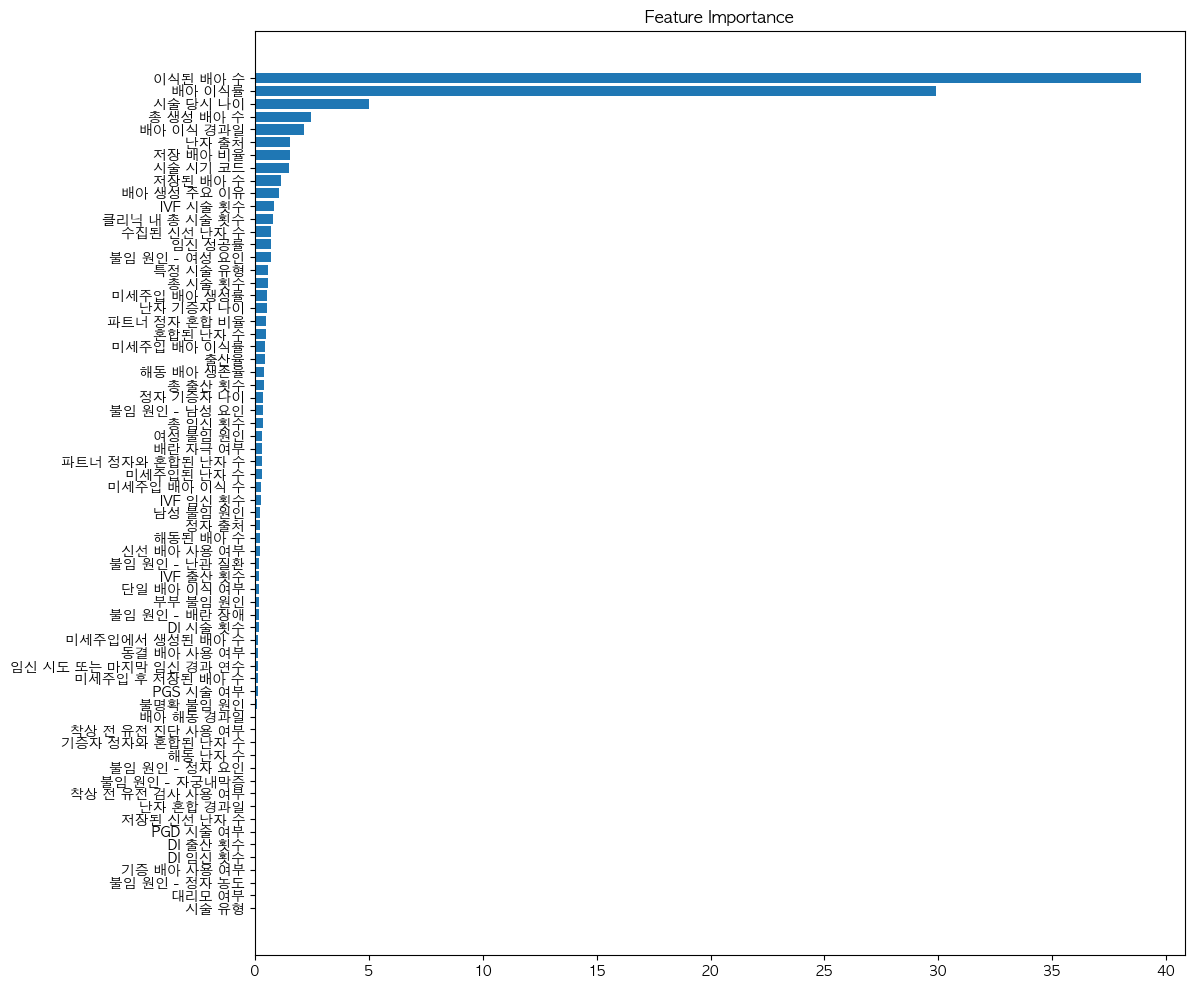

In [29]:
feature_importance = model_cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

In [30]:
np.array(X.columns)[sorted_idx][::-1]

array(['이식된 배아 수', '배아 이식률', '시술 당시 나이', '총 생성 배아 수', '배아 이식 경과일',
       '난자 출처', '저장 배아 비율', '시술 시기 코드', '저장된 배아 수', '배아 생성 주요 이유',
       'IVF 시술 횟수', '클리닉 내 총 시술 횟수', '수집된 신선 난자 수', '임신 성공률',
       '불임 원인 - 여성 요인', '특정 시술 유형', '총 시술 횟수', '미세주입 배아 생성률', '난자 기증자 나이',
       '파트너 정자 혼합 비율', '혼합된 난자 수', '미세주입 배아 이식률', '출산율', '해동 배아 생존율',
       '총 출산 횟수', '정자 기증자 나이', '불임 원인 - 남성 요인', '총 임신 횟수', '여성 불임 원인',
       '배란 자극 여부', '파트너 정자와 혼합된 난자 수', '미세주입된 난자 수', '미세주입 배아 이식 수',
       'IVF 임신 횟수', '남성 불임 원인', '정자 출처', '해동된 배아 수', '신선 배아 사용 여부',
       '불임 원인 - 난관 질환', 'IVF 출산 횟수', '단일 배아 이식 여부', '부부 불임 원인',
       '불임 원인 - 배란 장애', 'DI 시술 횟수', '미세주입에서 생성된 배아 수', '동결 배아 사용 여부',
       '임신 시도 또는 마지막 임신 경과 연수', '미세주입 후 저장된 배아 수', 'PGS 시술 여부',
       '불명확 불임 원인', '배아 해동 경과일', '착상 전 유전 진단 사용 여부', '기증자 정자와 혼합된 난자 수',
       '해동 난자 수', '불임 원인 - 정자 요인', '불임 원인 - 자궁내막증', '착상 전 유전 검사 사용 여부',
       '난자 혼합 경과일', '저장된 신선 난자 수', 'PGD 시술 여부', 'DI 출산 횟수', 'DI 임신 횟수',
       '기증 배아 사용 여부', '불임 원인 - 정자 농도

In [31]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13553.,  2405.,  3311.,  6035.,  9323., 13347., 16801., 15206.,
         9554.,   532.]),
 array([5.80953783e-04, 8.89236476e-02, 1.77266341e-01, 2.65609035e-01,
        3.53951729e-01, 4.42294423e-01, 5.30637116e-01, 6.18979810e-01,
        7.07322504e-01, 7.95665198e-01, 8.84007892e-01]),
 <BarContainer object of 10 artists>)

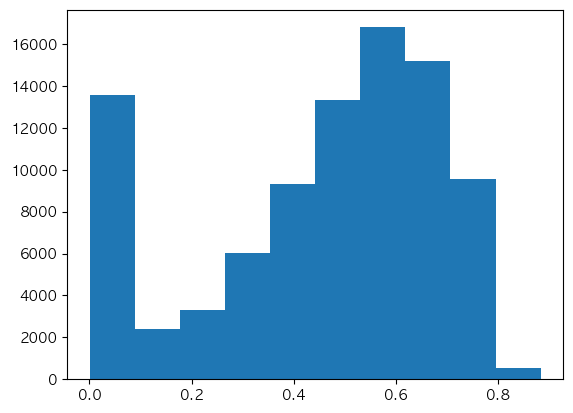

In [32]:
plt.hist(test_pred_total_mean)

In [81]:
from sklearn.ensemble import StackingClassifier  
from sklearn.linear_model import LogisticRegression  
from sklearn.preprocessing import LabelEncoder

# 전체 학습 데이터를 이용하여 Stacking Ensemble 구성 (기반 모델: CatBoost, LightGBM / Meta learner: LogisticRegression)
# 재현성 확인 시 저장된 튜닝 파라미터의 첫번째 값을 사용
best_cat_params = loaded_cat_cpu_params[0]
best_lgbm_params = loaded_lgbm_params[0]

# 전체 데이터의 클래스 불균형 보정을 위한 class_weight 계산
class_weights_all = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weight_dict_all = {i: w for i, w in enumerate(class_weights_all)}

# CatBoost를 사용할 때 categorical feature를 문자열 그대로 넣지 않고 Label Encoding 적용
def label_encode_features(df, categorical_columns):
    df = df.copy()
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    return df

# 학습 데이터 및 테스트 데이터 변환
X_encoded = label_encode_features(X, categorical_columns)
test_encoded = label_encode_features(test, categorical_columns)

# 개별 모델 정의 (CatBoost는 categorical_features 사용하지 않고 변환된 데이터 활용)
stack_cat = CatBoostClassifier(**best_cat_params,
                               auto_class_weights='Balanced', 
                               eval_metric='AUC',
                               random_state=seed, 
                               task_type="CPU", 
                               verbose=300)

stack_lgbm = lgb.LGBMClassifier(**best_lgbm_params, class_weight=class_weight_dict_all)

# Stacking 모델 정의
stacking_model = StackingClassifier(
    estimators=[
        ('catboost', stack_cat),
        ('lgbm', stack_lgbm)
    ],
    final_estimator=LogisticRegression(),
    cv=10,
    n_jobs=-1,
    passthrough=True
)

# 학습 시작 (Categorical Features는 이미 변환했으므로 추가 옵션 필요 없음)
stacking_model.fit(X_encoded, y)

0:	total: 98.8ms	remaining: 4m 20s
300:	total: 6.12s	remaining: 47.5s
600:	total: 11.8s	remaining: 40s
900:	total: 17.5s	remaining: 33.8s
1200:	total: 23.1s	remaining: 27.6s
1500:	total: 28.6s	remaining: 21.7s
1800:	total: 34s	remaining: 15.8s
2100:	total: 38.9s	remaining: 9.93s
2400:	total: 43.3s	remaining: 4.28s
2637:	total: 46.8s	remaining: 0us
0:	total: 362ms	remaining: 15m 55s
0:	total: 206ms	remaining: 9m 2s
0:	total: 217ms	remaining: 9m 33s
0:	total: 186ms	remaining: 8m 9s
0:	total: 176ms	remaining: 7m 43s
0:	total: 207ms	remaining: 9m 5s
0:	total: 140ms	remaining: 6m 8s
0:	total: 95.9ms	remaining: 4m 12s
0:	total: 237ms	remaining: 10m 25s
0:	total: 172ms	remaining: 7m 32s
300:	total: 52.7s	remaining: 6m 49s
300:	total: 53.8s	remaining: 6m 57s
300:	total: 54s	remaining: 6m 58s
300:	total: 54.7s	remaining: 7m 4s
300:	total: 54.6s	remaining: 7m 4s
300:	total: 55.4s	remaining: 7m 9s
300:	total: 55.9s	remaining: 7m 13s
300:	total: 55.9s	remaining: 7m 13s
300:	total: 56.7s	remaining:

StackingClassifier(cv=10,
                   estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x31f0e5250>),
                               ('lgbm',
                                LGBMClassifier(class_weight={0: 0.6741714574249302,
                                                             1: 1.935367216283143},
                                               colsample_bytree=0.6,
                                               learning_rate=0.005593066320046345,
                                               metric='auc',
                                               min_child_samples=35,
                                               n_estimators=1996,
                                               objective='binary',
                                               random_state=42, subsample=0.5,
                                               verbose=-1))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   passthrough=True)

In [82]:
from sklearn.model_selection import cross_val_score

stacking_auc_scores = cross_val_score(stacking_model, X_encoded, y, cv=10, scoring='roc_auc')

print("Stacking Model Cross-Validation AUC Scores:", stacking_auc_scores)

print("Stacking Model Mean AUC Score:", stacking_auc_scores.mean())

0:	total: 86.9ms	remaining: 3m 49s
300:	total: 5.59s	remaining: 43.4s
600:	total: 10.8s	remaining: 36.8s
900:	total: 16s	remaining: 30.8s
1200:	total: 21.1s	remaining: 25.2s
1500:	total: 26.1s	remaining: 19.8s
1800:	total: 31s	remaining: 14.4s
2100:	total: 35.6s	remaining: 9.11s
2400:	total: 39.8s	remaining: 3.92s
2637:	total: 43s	remaining: 0us
0:	total: 121ms	remaining: 5m 19s
0:	total: 218ms	remaining: 9m 36s
0:	total: 127ms	remaining: 5m 33s
0:	total: 353ms	remaining: 15m 32s
0:	total: 234ms	remaining: 10m 16s
0:	total: 198ms	remaining: 8m 42s
0:	total: 171ms	remaining: 7m 30s
0:	total: 240ms	remaining: 10m 32s
0:	total: 175ms	remaining: 7m 41s
0:	total: 179ms	remaining: 7m 52s
300:	total: 44.3s	remaining: 5m 43s
300:	total: 45.9s	remaining: 5m 56s
300:	total: 46.2s	remaining: 5m 58s
300:	total: 46.4s	remaining: 6m
300:	total: 46.5s	remaining: 6m 1s
300:	total: 46.9s	remaining: 6m 4s
300:	total: 46.9s	remaining: 6m 3s
300:	total: 47.6s	remaining: 6m 9s
300:	total: 48.1s	remaining: 

In [84]:
stacking_test_pred = stacking_model.predict_proba(test_encoded)[:, 1]

# Stacking 모델 예측 결과로 submission 파일 생성
sample_submission_stacking = pd.read_csv('../sample_submission.csv')
sample_submission_stacking['probability'] = stacking_test_pred
sample_submission_stacking.to_csv('Add_feature_reason2_lgbmcat_cpu_mac_sunghyun+StackingBlending.csv', index=False)